In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output
from scipy.stats import chisquare


%matplotlib inline


In [65]:
cd /Users/austinmcdonald/Desktop/101817-test/cut/spot4

/Users/austinmcdonald/Desktop/101817-test/Cut/Spot4


In [66]:
files = os.listdir()
files = [x for x in files if x != '.DS_Store']
#files[0:10]
#files = files[1:]
#files = files[0:150]
#files

In [67]:
eCoeff = 0.01160
eOffset= 1917
SpotInfo2 = []
AllPairs =[]
Shape = 221
Row = int(4) # define the area to take around the spots
Col = int(4) # define the area to take around the spots
xvs = np.arange(0,Shape)
#DataS=np.zeros(Shape**2).reshape((Shape,Shape))
neighborhood_size = 9

DataSub = np.zeros(Shape**2).reshape((Shape,Shape))

eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))

    
MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
for x in range(700,750):
    Images = np.array(Image.open(files[x]))
    Images = eCoeffM*(Images - eOffsetM) ######################################## 
    ImageFit = []
    for y in range(0,Shape):
        coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        ImageFit.append(ffit)
    MeanFit+=np.array(ImageFit)
MeanFit = MeanFit/50

for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])) )###################### - MeanFit
    Images = eCoeffM*(Images - eOffsetM) - MeanFit ######################################## 
    DataSub += Images


data = DataSub

threshold = np.mean(data)+3*np.std(data)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 
        
clear_output()
print('Finding AllPairs')
print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))   
Images = None
ImageB = None
#data   = None
Slices = None
labeled= None
num_objects=None
    
############################################################## 


Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>10 and XX<210 and YY>10 and YY<210:
        Xc.append(XX)
        Yc.append(YY)


for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])) )#- MeanFit)################### 
    Images = eCoeffM*(Images - eOffsetM) - MeanFit ######################################## 
    Images[Images<0]=0
    SpotInfoHolder = []

    for w in range(0,len(Xc)):
        Xindex = int(Xc[w])
        Yindex = int(Yc[w])
        spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot = spot1[2:7,2:7]
        SpotRemove = np.zeros(5**2).reshape((5,5))
        spot2[2:7,2:7]=SpotRemove
        spotB = spot2

        ATot = spot.sum()
        ATotB = spot2.sum()
        SpotInfo2.append([q,Xindex,Yindex,ATot,ATotB])

##############################################################  
 
    clear_output()
    print('Finding all areas') 
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))


Finding all areas
On file 750 of 750


In [68]:
len(AllPairs)

104

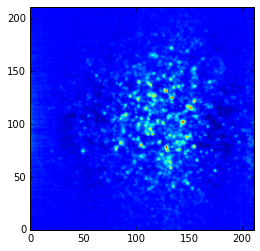

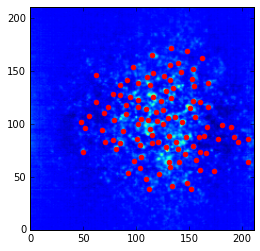

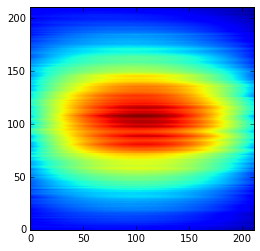

In [69]:
dd=np.array(DataSub)
plt.imshow(dd)
plt.xlim(0,211)
plt.ylim(0,211)
plt.show()
plt.imshow(dd)
plt.xlim(0,211)
plt.ylim(0,211)
plt.scatter(Xc,Yc,color='r')
plt.show()
tt = np.array(MeanFit)
plt.imshow(tt)
plt.xlim(0,211)
plt.ylim(0,211)
plt.show()

In [70]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [71]:
Par = len(AllPairs)
AVG = 5
Mnumb = 10
PairsMade=[]
Tau = []
Signal = []
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,4]*(25/56)
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
    vals =np.arange(0,len(aa))

    coefs = poly.polyfit(vals,aaB, 3)
    ffit  = poly.polyval(vals, coefs)
    Sig = np.array(aa-ffit)
                                
    meanI = np.mean(Sig[:Mnumb])
    sigmaI = np.std(Sig[:Mnumb])
    meanE = np.mean(Sig[-Mnumb:])
    sigmaE = np.std(Sig[-Mnumb:])
    meanM = np.mean(Sig)
    T = len(Sig)
    tau = ((meanM - meanE)/(meanI -meanE))*T
    Tau.append(tau)
    Signal.append(Sig)

Tau2 = []
Offset = 5
for x in range(0,Par):
    TauH = Tau[x]
    for q in range(0,50):
        meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
        meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau2.append(TauH)
    
    
Tau3 = []
Offset = 3
for x in range(0,Par):
    TauH = Tau2[x]
    for q in range(0,50):
        meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
        meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau3.append(TauH)

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [72]:
len(Tau3)

104

In [73]:
data = []
PairsMade = []
chiF = []
chiB = []
chiFIT=[]
chiRa = []
meanDif = []
Dtau = []

Offset =3
for x in range(0,Par):
    TauH   = Tau3[x]
    Data = running_mean(Signal[x],4)
    DataLeft  = Data[:int(TauH)-Offset]
    DataRight = Data[int(TauH)+Offset:]
    sigma = np.std(Data)
    mean  = np.mean(Data)
    meanI  = np.mean(DataLeft)
    sigmaI = np.std(DataLeft)
    meanE  = np.mean(DataRight)
    sigmaE = np.std(DataRight)
    Inten  = Signal[x][:int(TauH)]
    Intensity  = np.sum(Inten)/len(Inten)

    chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
    chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
    
    val = np.arange(0,len(Data),1)
    fit=np.polyfit(val,Data,1)    
    chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
    
    dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
    if  True:#meanI-2*sigmaI > meanE+2*sigmaE and TauH>0:
        data.append([Signal[x],TauH,Intensity])
        PairsMade.append(AllPairs[x])
        chiF.append(chiHIGH)
        chiB.append(chiLOW)
        chiFIT.append(chiFit)
        chiRa.append((chiLOW+chiHIGH)/ chiFit)
        meanDif.append(meanI-meanE)
        Dtau.append(dtau)
len(data)

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


104

Chi ratio =  0.023230530796
tau = 43.7585374023 +/- 8.04180268821


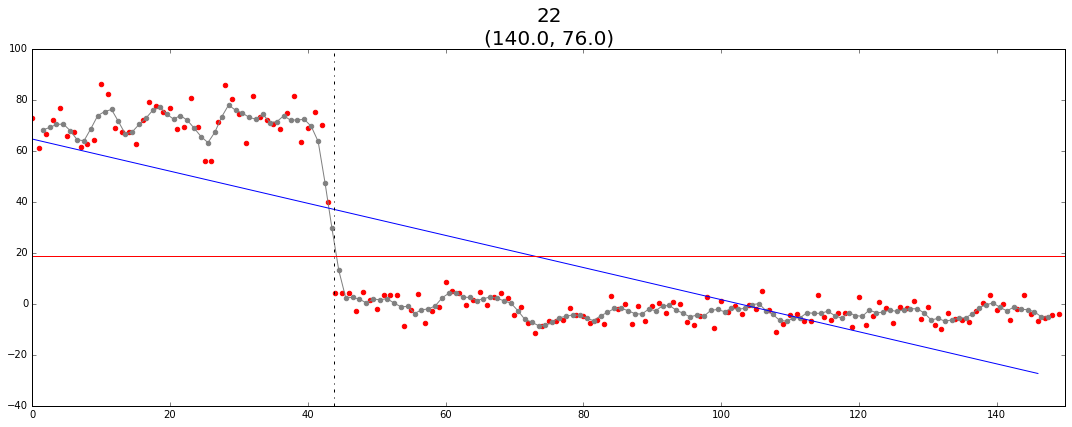

Chi ratio =  0.518710466074
tau = 90.7007241919 +/- 8.18331694519


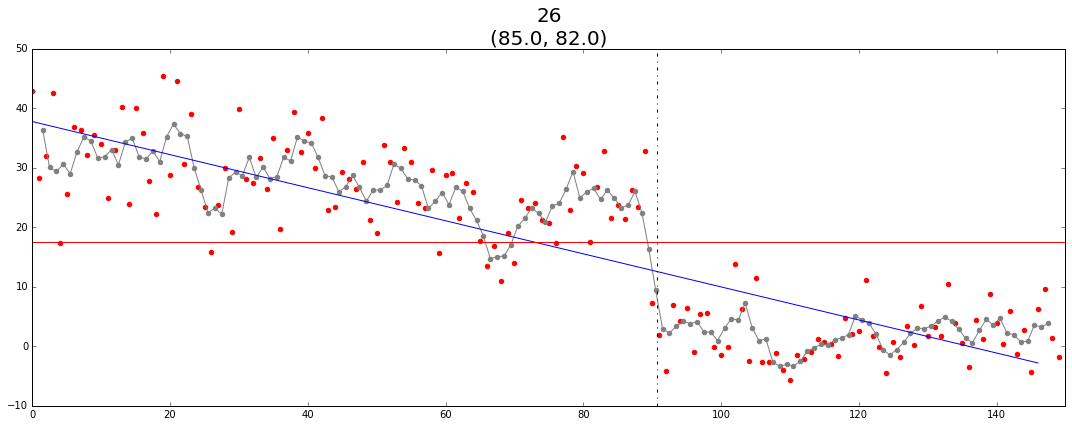

Chi ratio =  0.133027542392
tau = 41.8008873323 +/- 7.57208491623


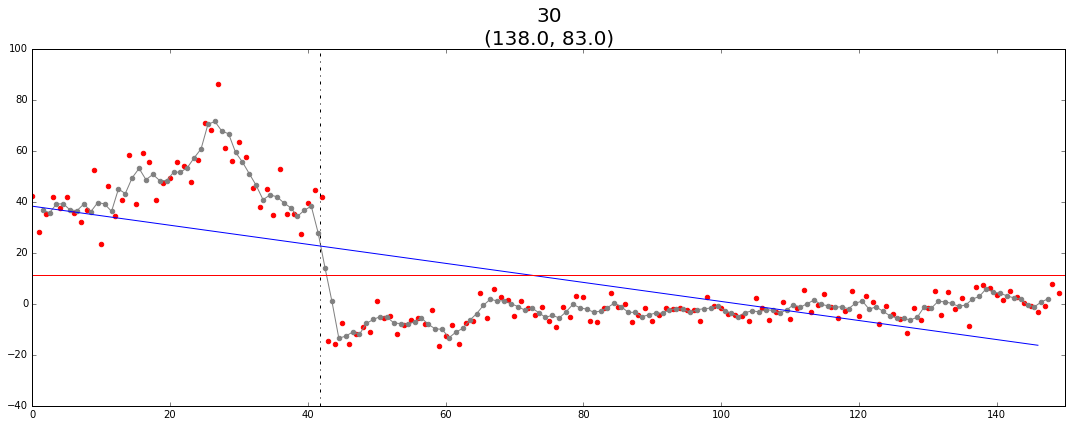

Chi ratio =  0.46976078016
tau = 34.0451019409 +/- 4.88336167688


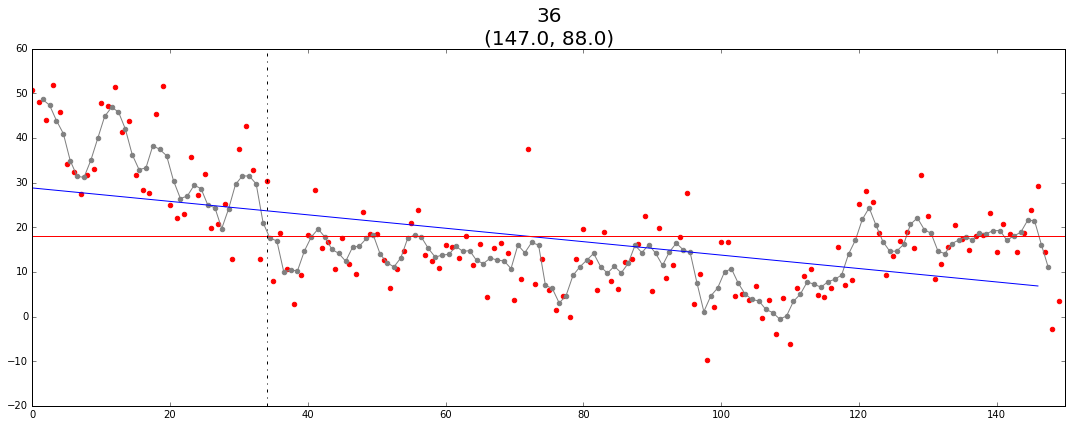

Chi ratio =  0.431132106359
tau = 56.2227416947 +/- 7.352355524


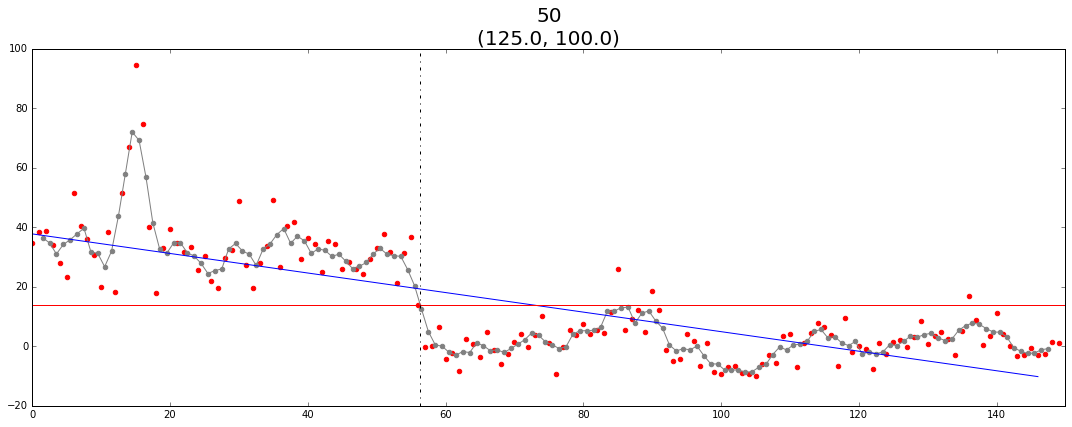

Chi ratio =  0.101223545356
tau = 47.8187987779 +/- 7.79285423963


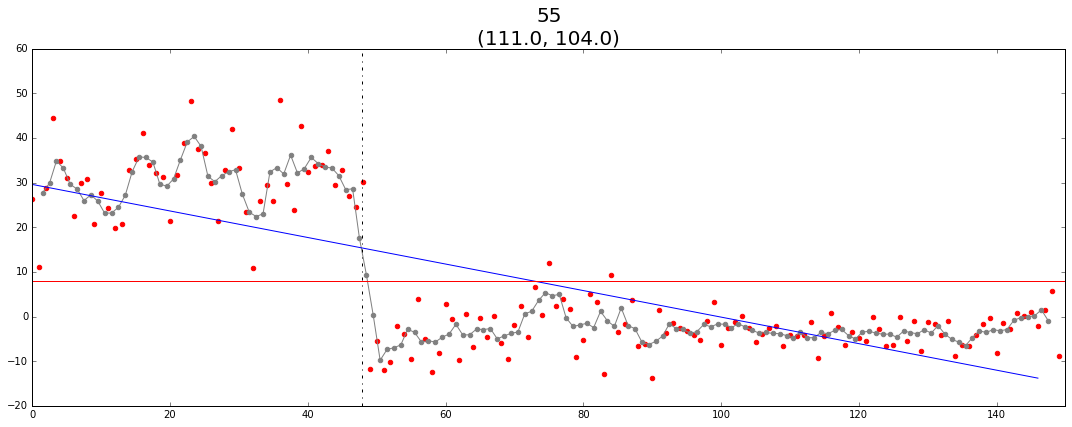

Chi ratio =  0.632099546651
tau = 140.918790833 +/- 7.22123316067


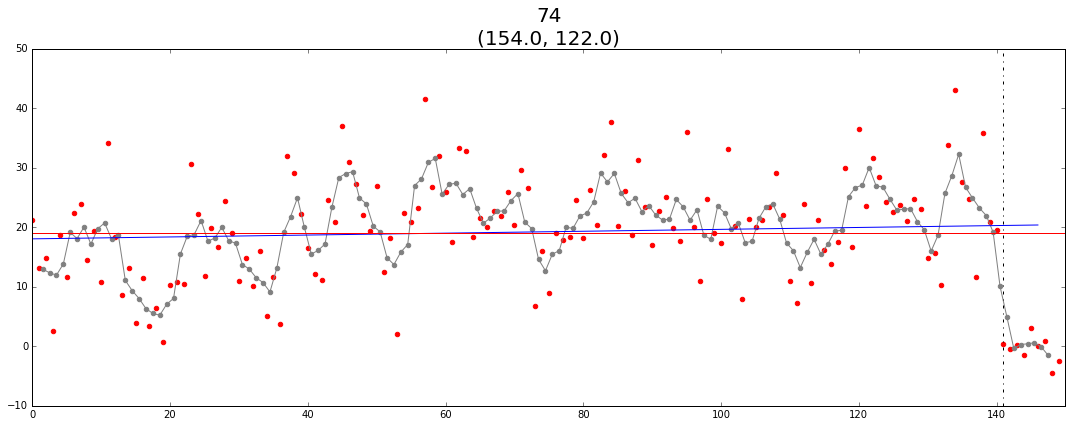

Chi ratio =  0.379653714322
tau = 107.238429983 +/- 7.14932365037


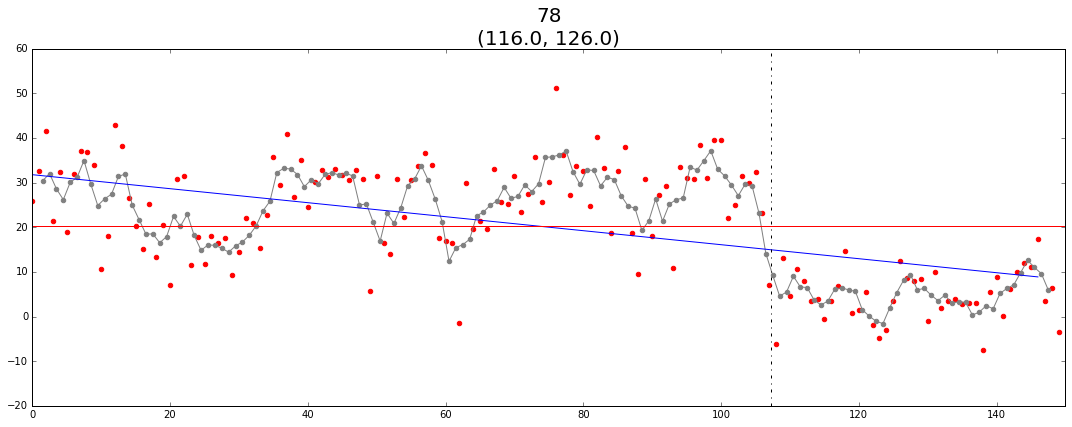

Chi ratio =  1.07194353529
tau = 92.8905078464 +/- 9.50803694033


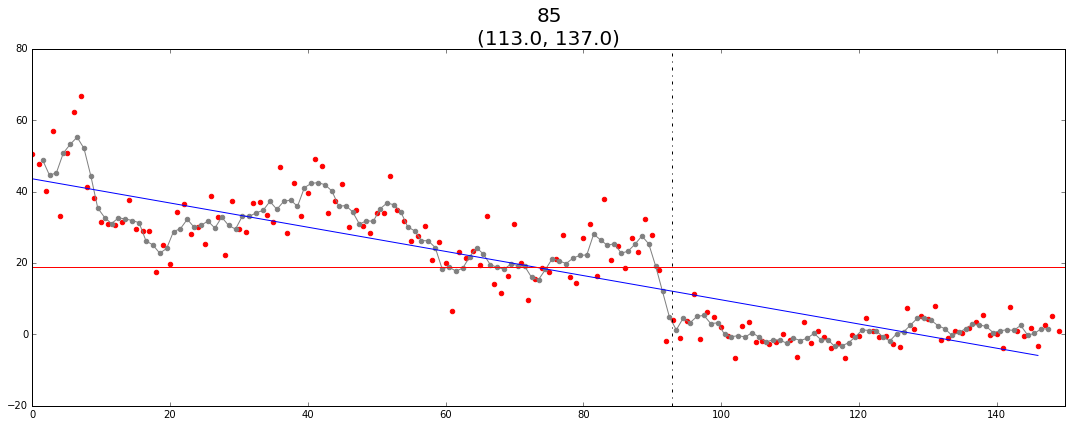

In [74]:
vals =np.arange(0,len(data[0][0]))
#vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))
K=4
for x in range(0,len(data)):
    if meanDif[x]>20 :#and chiRa[x]<1.2:
        plt.figure(figsize=(15,6))
        #plt.title(x,fontsize=20)
        print('Chi ratio = ',chiRa[x])
        print('tau =', str(data[x][1])+' '+"+/-"+' '+str(Dtau[x]/7.75))

        plt.title(str(x) +'\n'+str(PairsMade[x]),fontsize=20)
        plt.scatter(vals,data[x][0],color='r')
        plt.plot(running_mean(vals,K),running_mean(data[x][0],K),color='grey')
        plt.scatter(running_mean(vals,K),running_mean(data[x][0],K),color='grey')

        val = np.arange(0,len(running_mean(data[x][0],4)) ,1)
        fit=np.polyfit(val,running_mean(data[x][0],4),1)  
        plt.plot(val,fit[1]+val*fit[0],color='b')
        #plt.plot(val,(np.polyval(fit, val) - running_mean(data[x][0],4)))

        plt.axhline(np.mean(data[x][0]),linestyle ='-',color='r')

        plt.axvline(data[x][1],linestyle ='-.',color='k')
        plt.xlim(0,150)
        plt.tight_layout()
        plt.show()

In [198]:
print('All Pairs =',len(AllPairs))
print('Pairs Made =',len(PairsMade))
#print('Pairs Made2 =',len(PairsMade2))

All Pairs = 29
Pairs Made = 29


In [14]:
vals =np.arange(0,len(Signal[0]))
#vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))
K=4
for x in range(0,len(PairsMade)):
    
    sI = np.std(running_mean(Signal[x],4)[:int(Tau3[x])-Offset])
    mI = np.mean(running_mean(Signal[x],4)[:int(Tau3[x])-Offset])
    mE = np.mean(running_mean(Signal[x],4)[int(Tau3[x])+Offset:])
    sE = np.std(running_mean(Signal[x],4)[int(Tau3[x])+Offset:])
    
    plt.figure(figsize=(15,6))
    plt.title(x,fontsize=20)
    plt.scatter(vals,Signal[x],color='r')
    plt.plot(running_mean(vals,K),running_mean(Signal[x],K),color='grey')
    plt.scatter(running_mean(vals,K),running_mean(Signal[x],K),color='grey')

    #plt.axhline(70)
    #plt.axhline(0)
    #plt.axvline(Tau[x],linestyle ='--',color='k')
    plt.axhline(MeanM[x],linestyle ='-',color='r')
    #plt.axhline(MeanI[x],linestyle ='--',color='b')
    #plt.axhline(MeanE[x],linestyle ='--',color='m')
        
    #plt.axhline(MeanI2[x],color='b')
    #plt.axhline(MeanE2[x],color='m')
    plt.axvline(Tau2[x],color='k')
    plt.axvline(Tau3[x],linestyle ='--',color='k')

    plt.tight_layout()
    plt.show()
    if abs(mI-2*sI) > abs(mE+2*sE):
        print('pass')
    else:
        print('fail')
    print('I = ',abs(mI-2*sI))
    print('E = ',abs(mE+2*sE))

In [259]:
qq = np.array([3,7,4,5,6,4,5])
np.std(qq)

1.2453996981544784

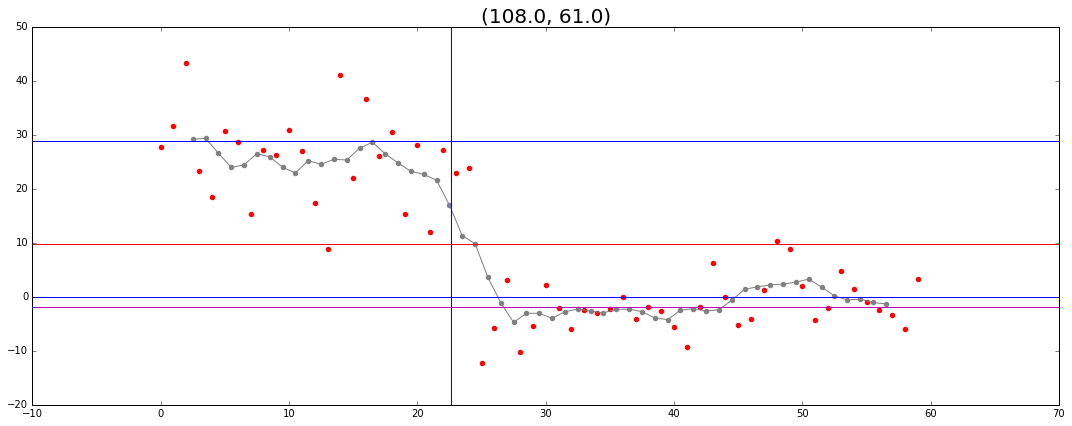

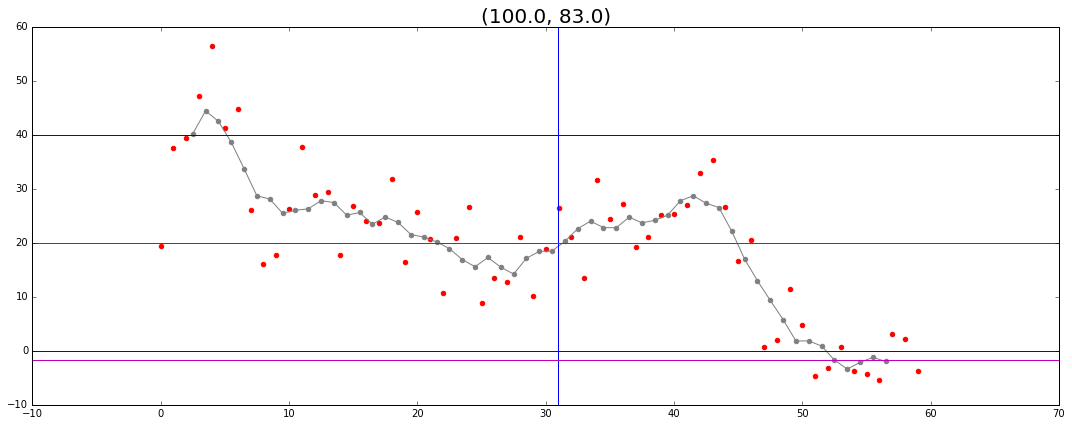

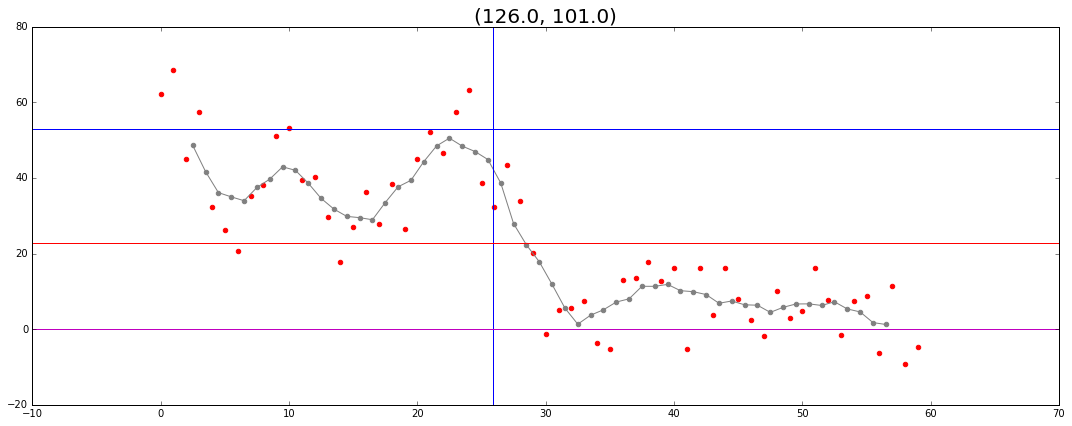

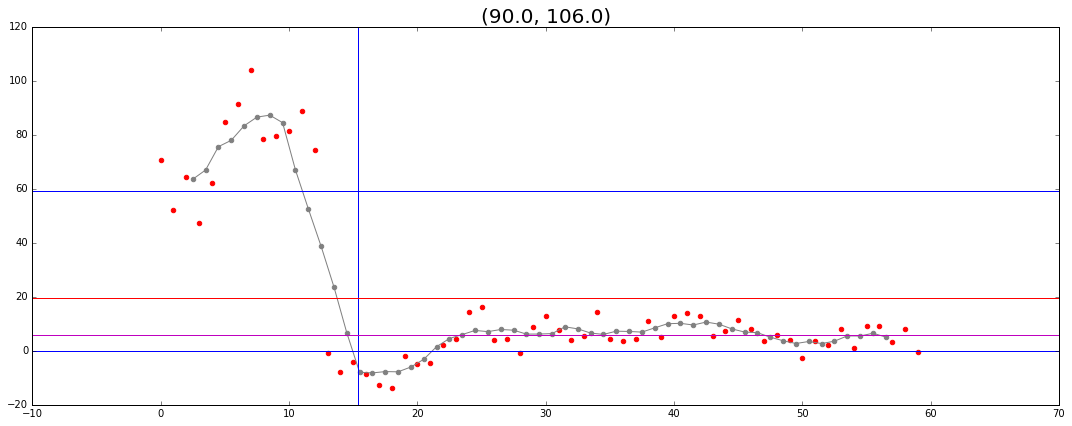

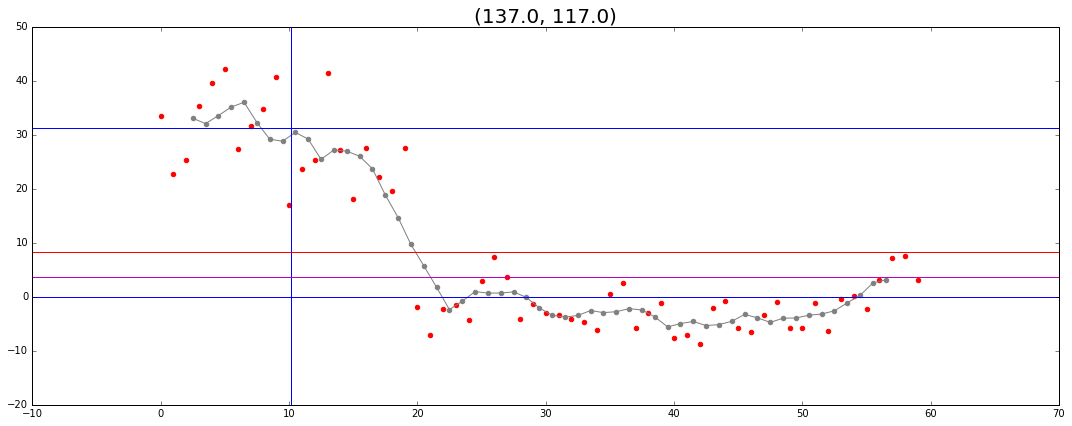

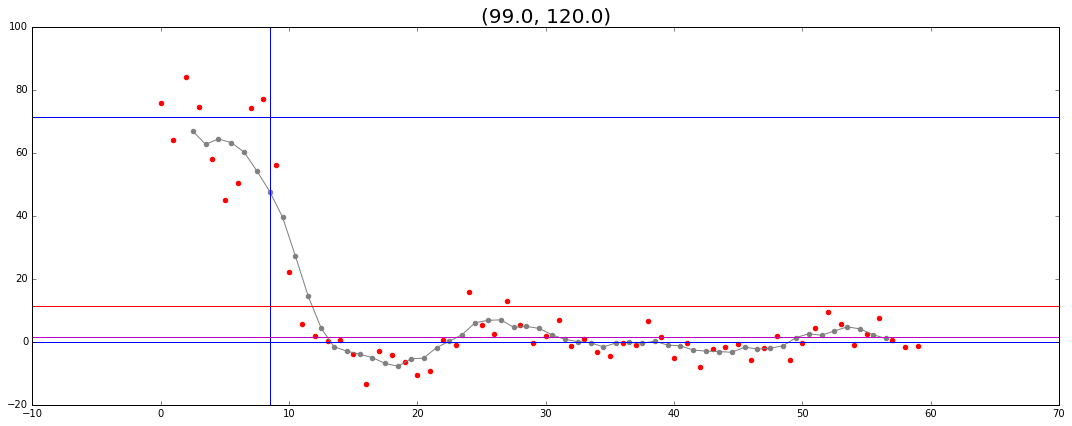

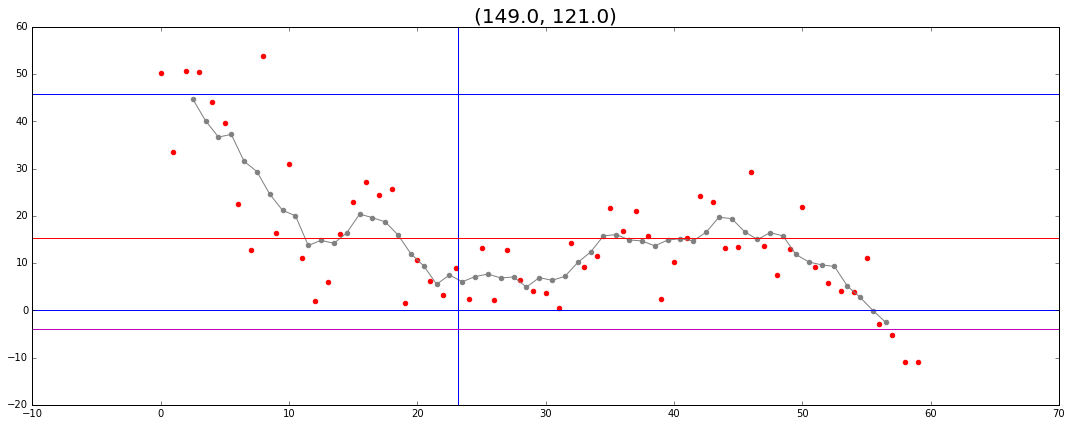

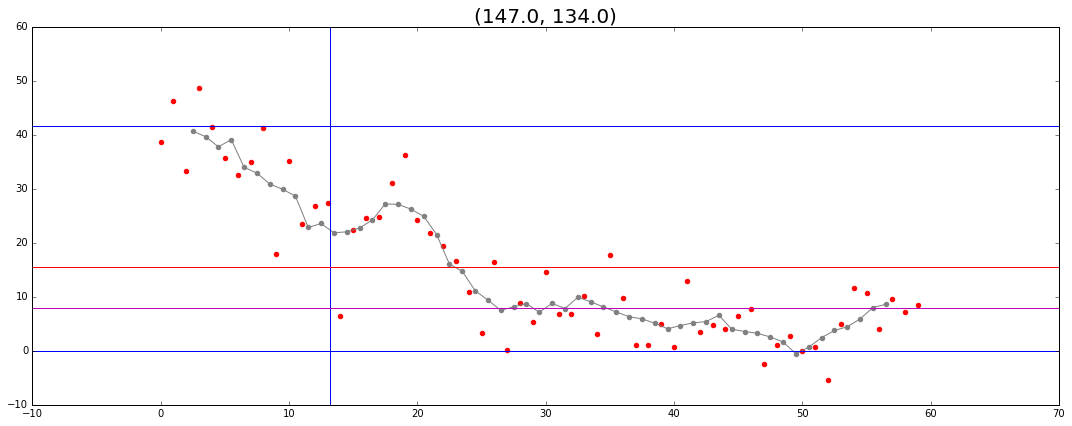

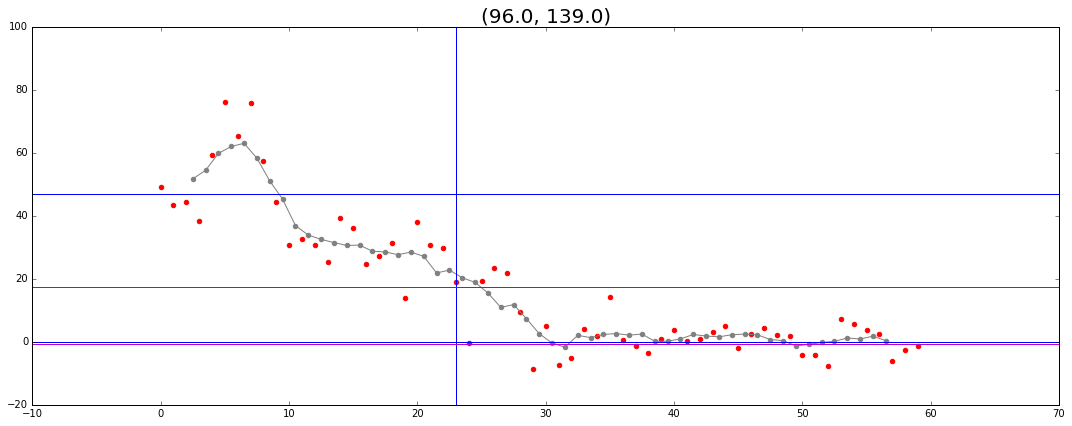

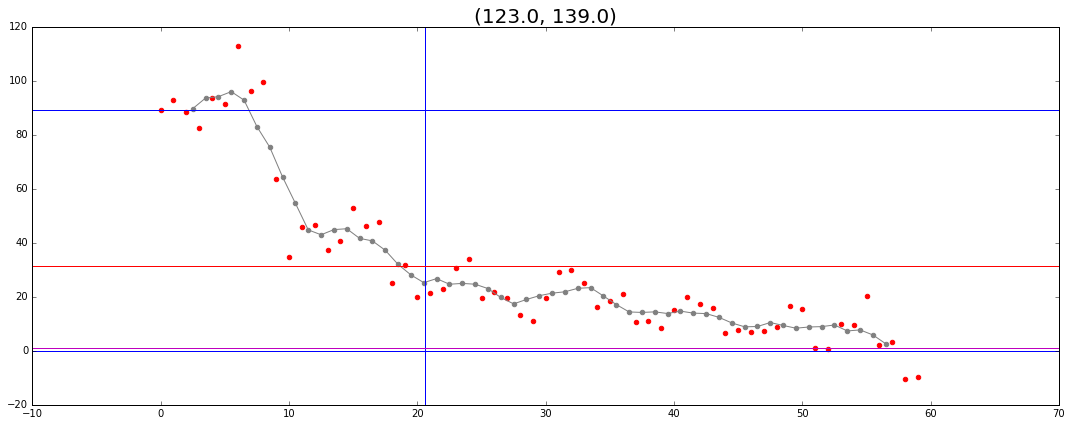

In [132]:
vals =np.arange(0,len(made[0]))
#vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))
K=6
for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    plt.scatter(vals,made[x],color='r')
    plt.plot(running_mean(vals,K),running_mean(made[x],K),color='grey')
    plt.scatter(running_mean(vals,K),running_mean(made[x],K),color='grey')
    
    #plt.scatter(vals,SpotAreaHHB[x],color='g')
    #plt.plot(vals,ffit)
    #plt.scatter(vals[gradval1[x][0][-1]+3:gradval1[x][0][-1]+3],SpotAreaHH2[x][gradval1[x]-5:gradval1[x]+5],color='k')

    
    #plt.plot(vals,np.gradient(SpotAreaHH[x]-SpotAreaHHB[x]))
    #plt.plot(vals,np.gradient(SpotAreaHH[x]),color='r')
    #plt.plot(vals,np.gradient(SpotAreaHHB[x]),color='g')
    #plt.scatter(vals,BackG[x])
    #plt.axvline(vals[Bleach[x]],color='steelblue',linewidth=2)
    
    #plt.axvline(vals[gradval1[x]],color='r',linewidth=2)
    plt.axvline(Tau[x])
    #plt.axhline(70)
    plt.axhline(0)
    plt.axhline(MeanM[x],color='r')
    plt.axhline(MeanI[x],color='b')
    plt.axhline(MeanE[x],color='m')

    #plt.axhline(20,color='g')

    plt.tight_layout()
    plt.show()

In [83]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 



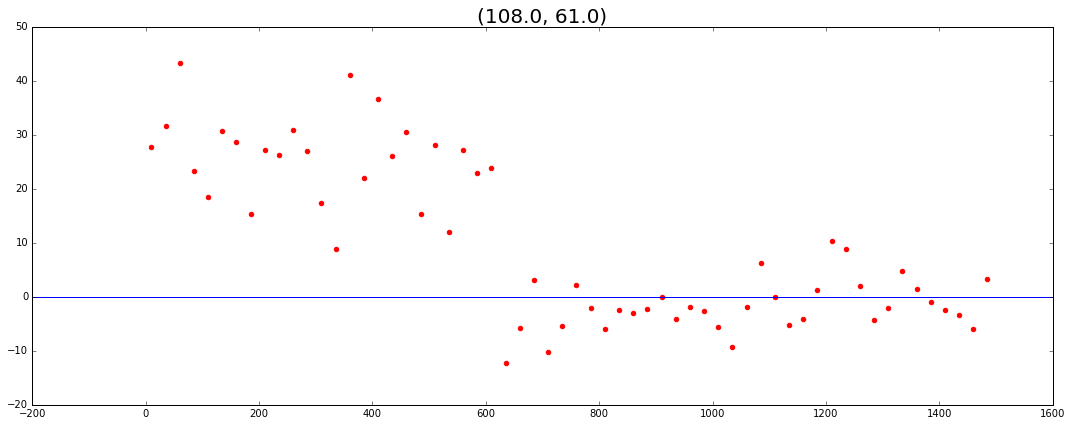

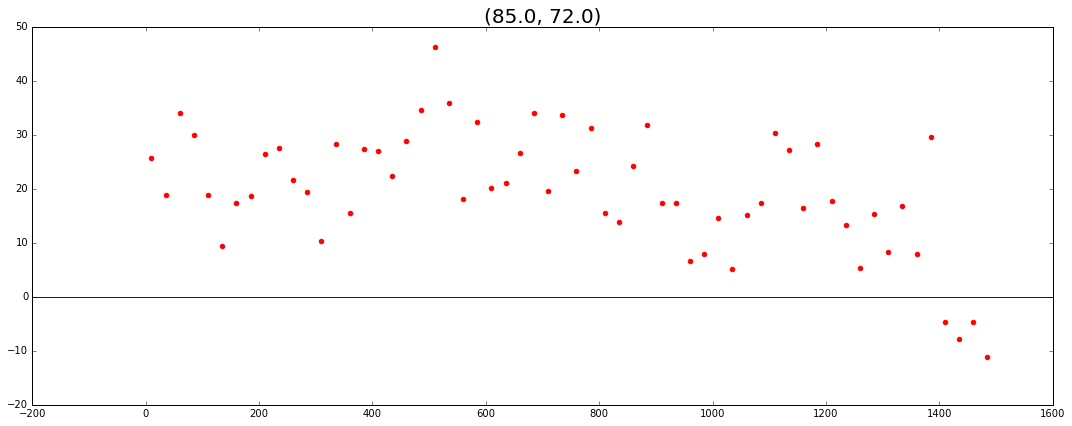

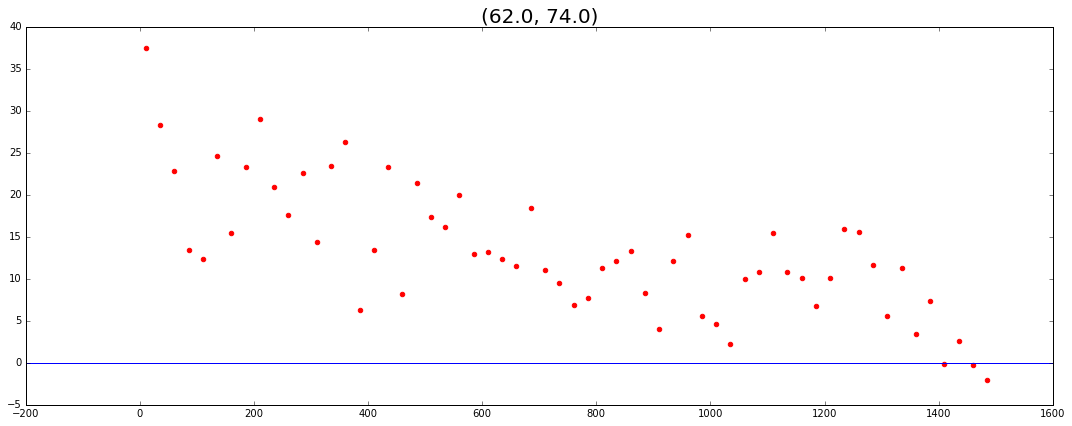

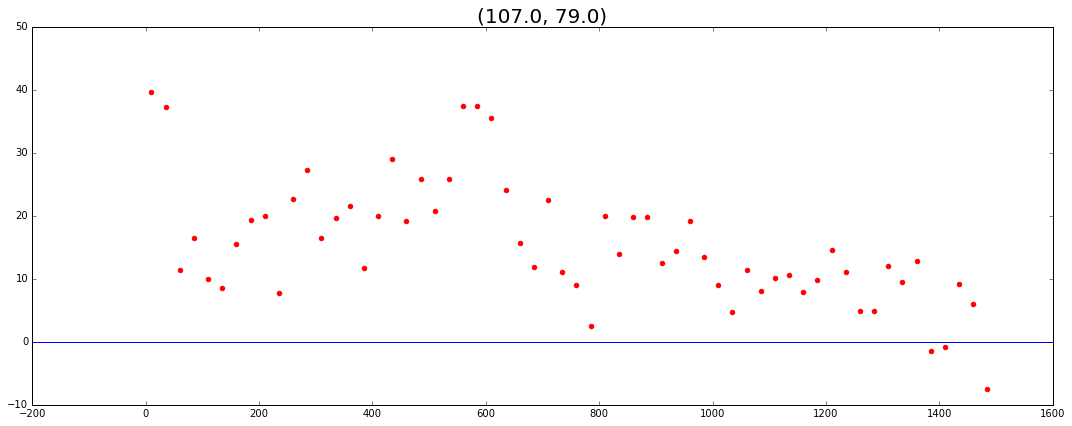

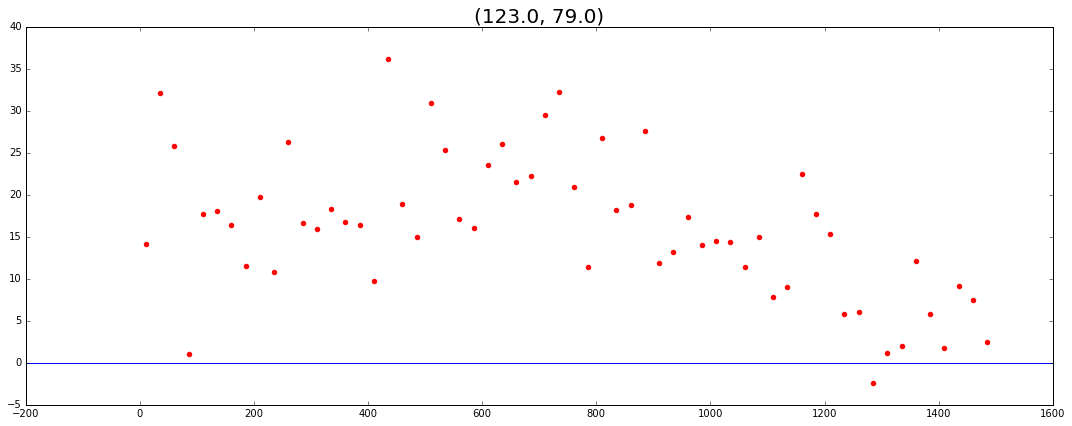

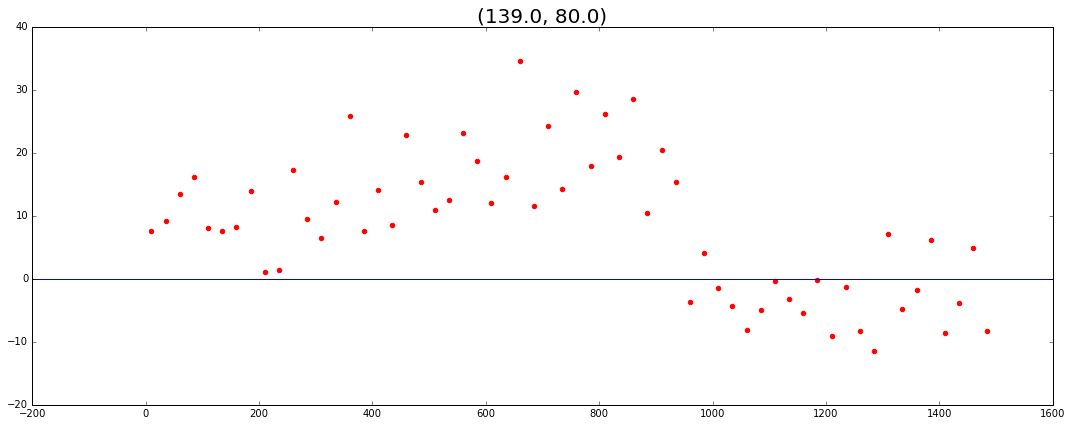

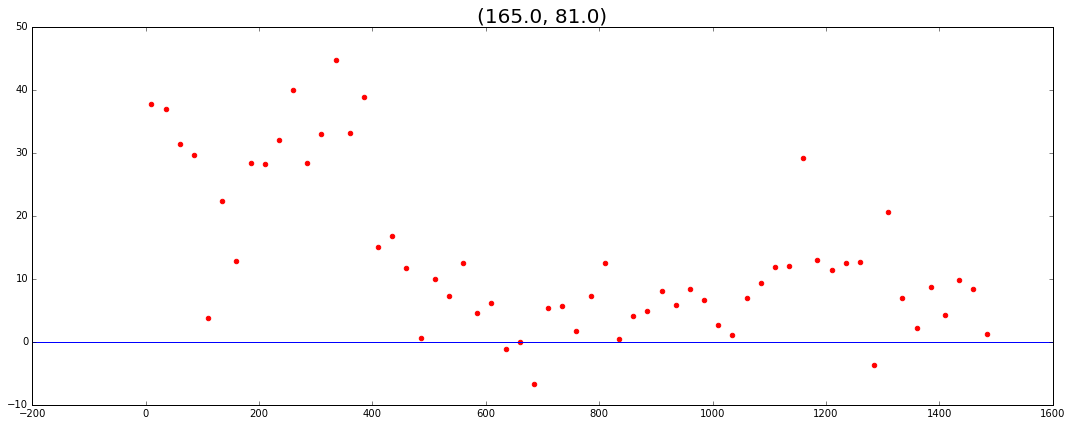

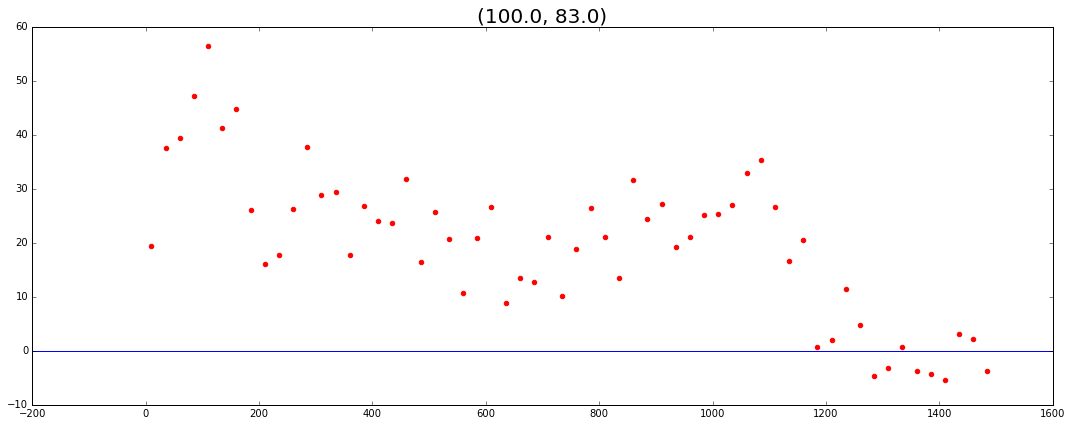

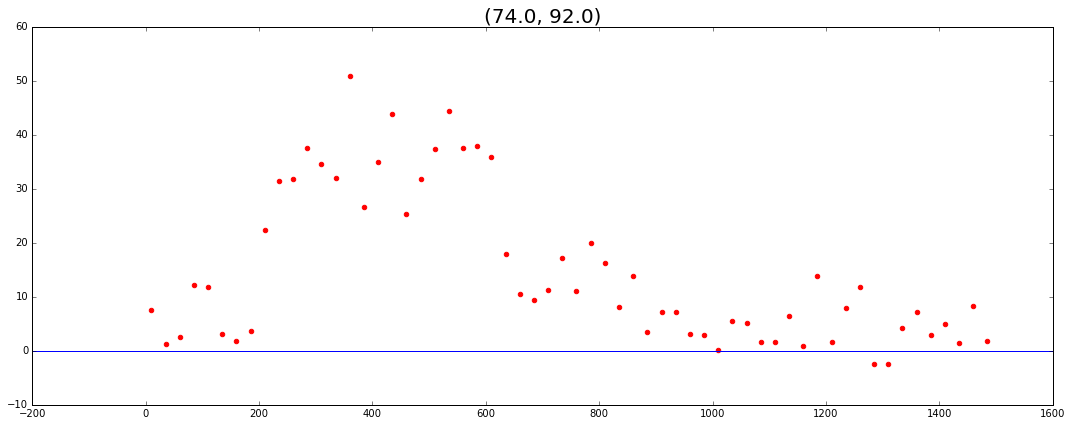

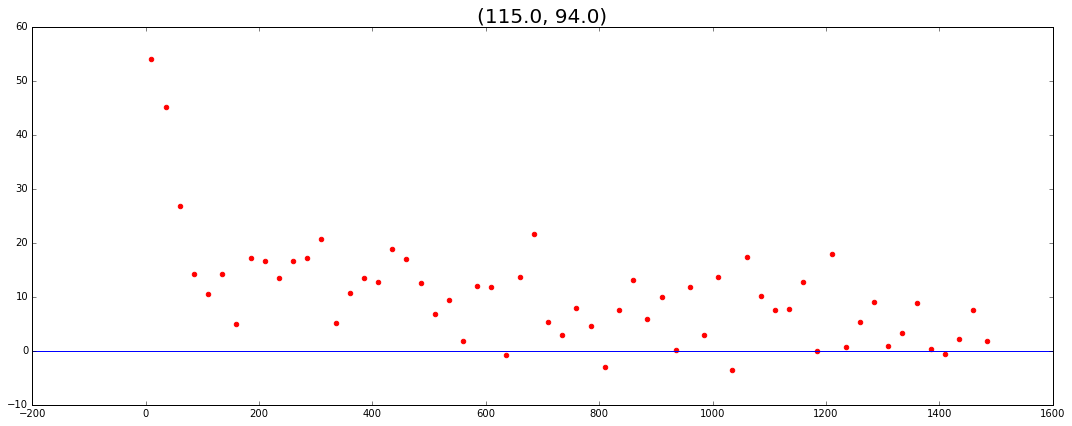

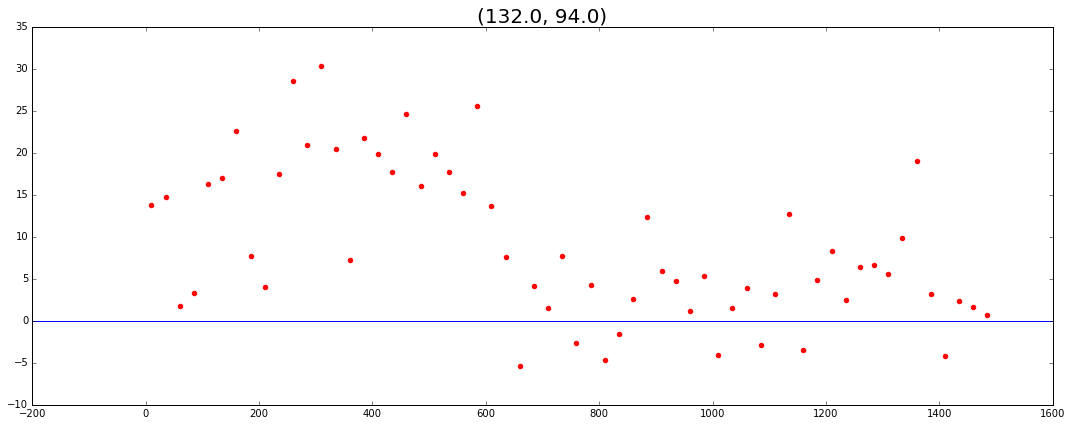

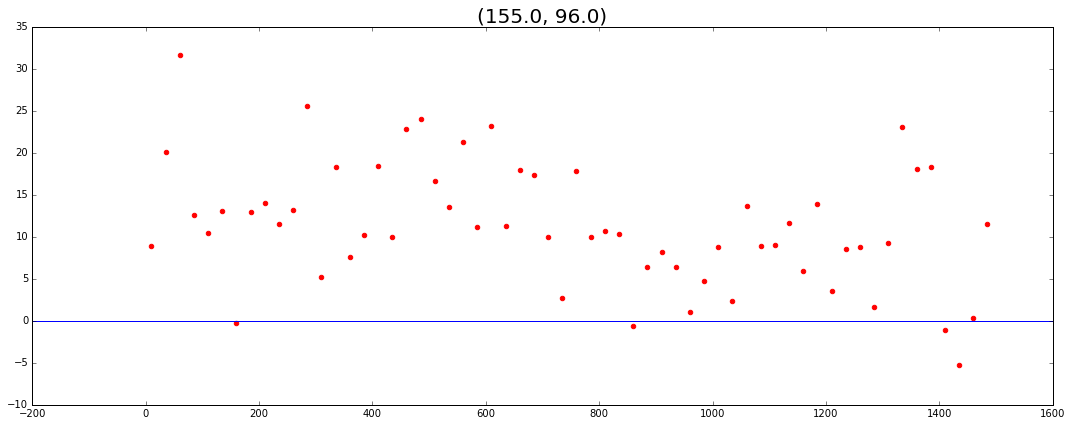

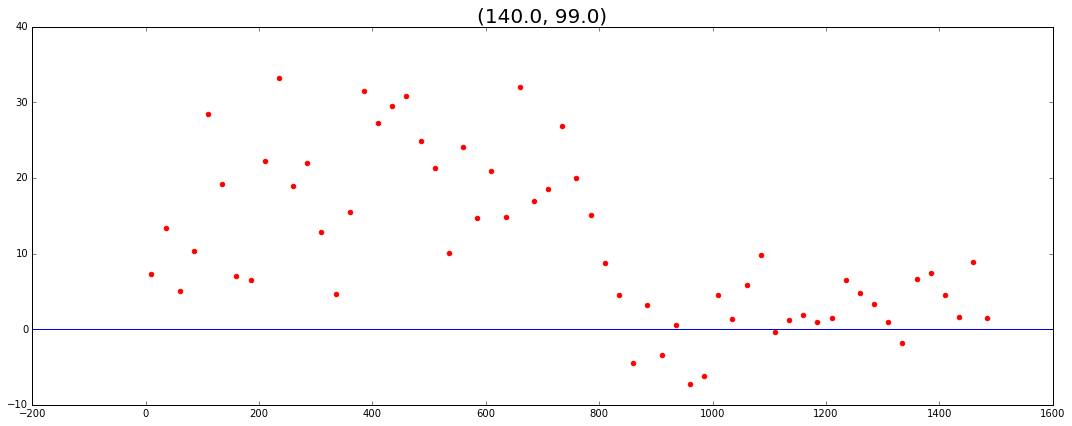

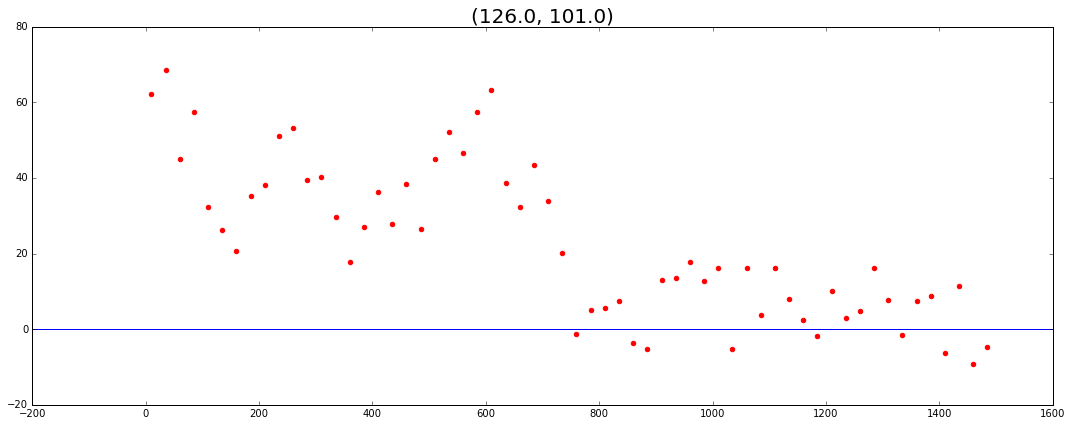

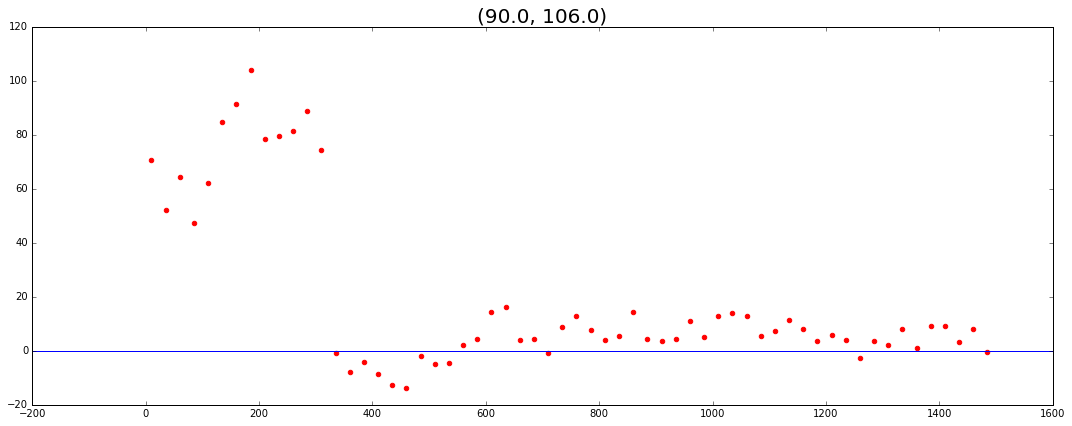

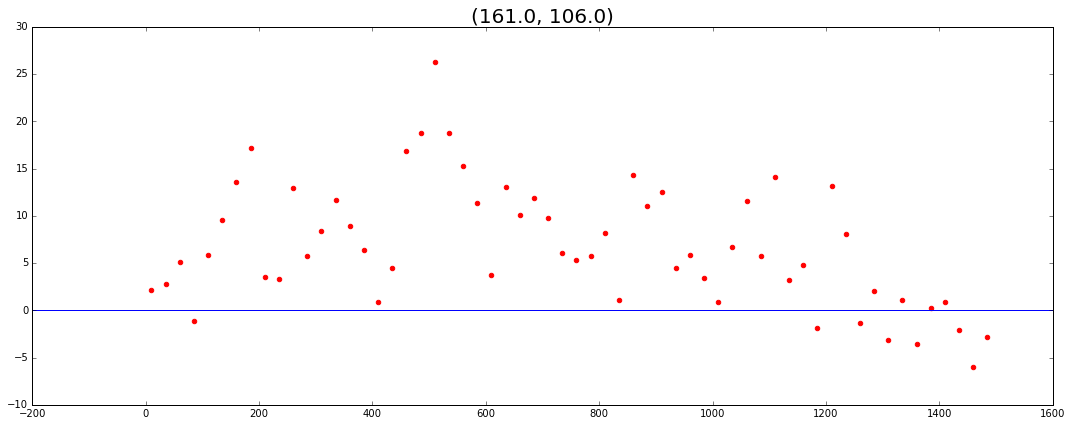

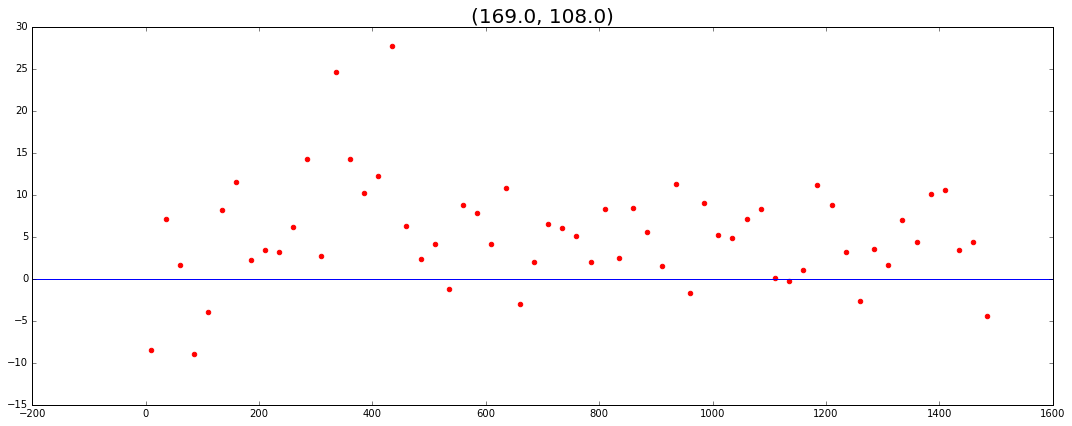

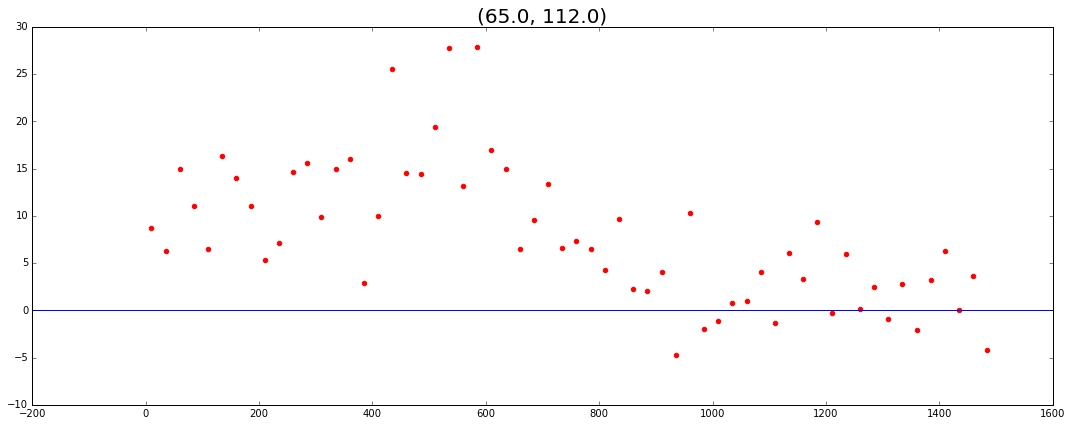

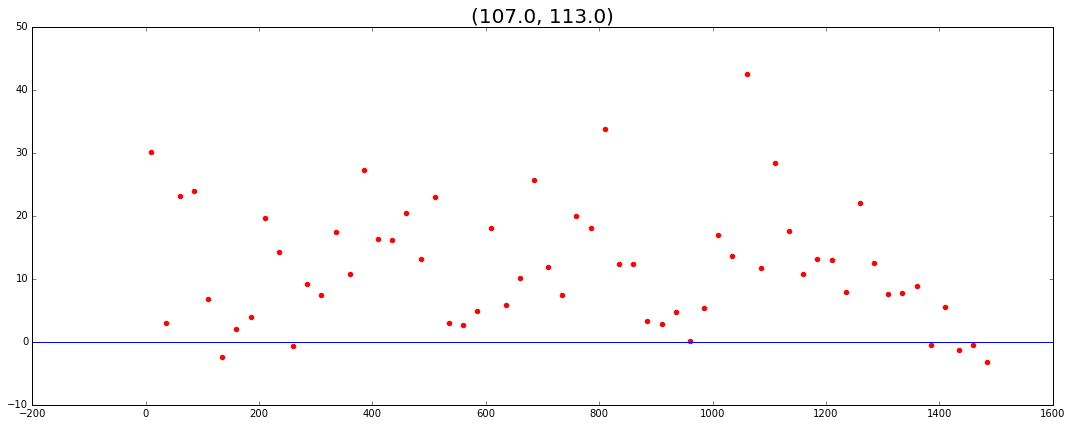

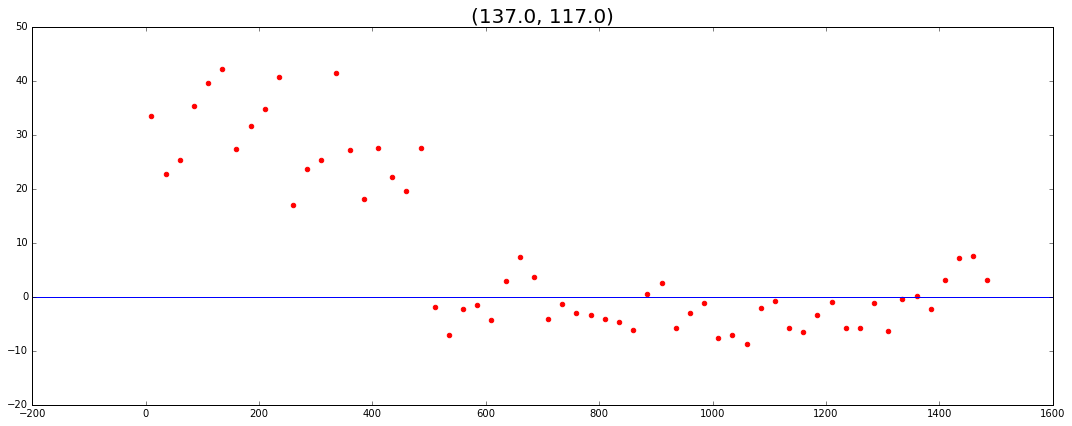

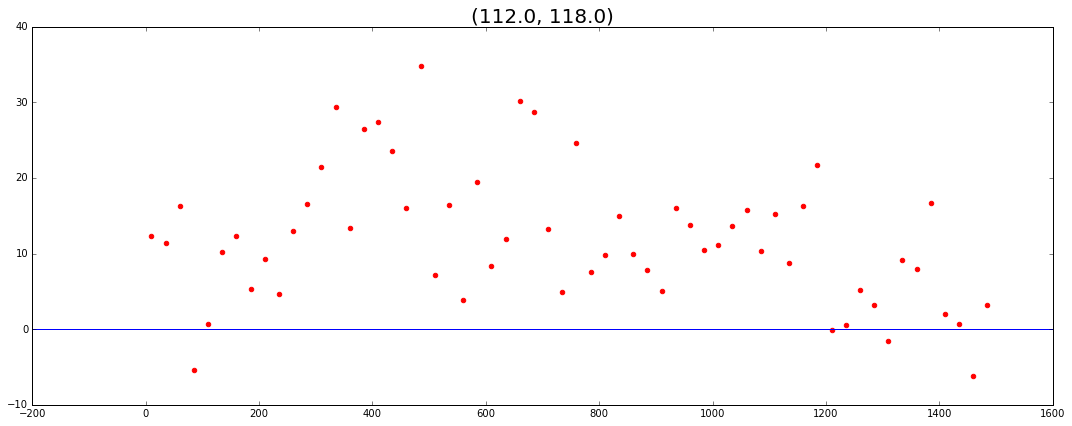

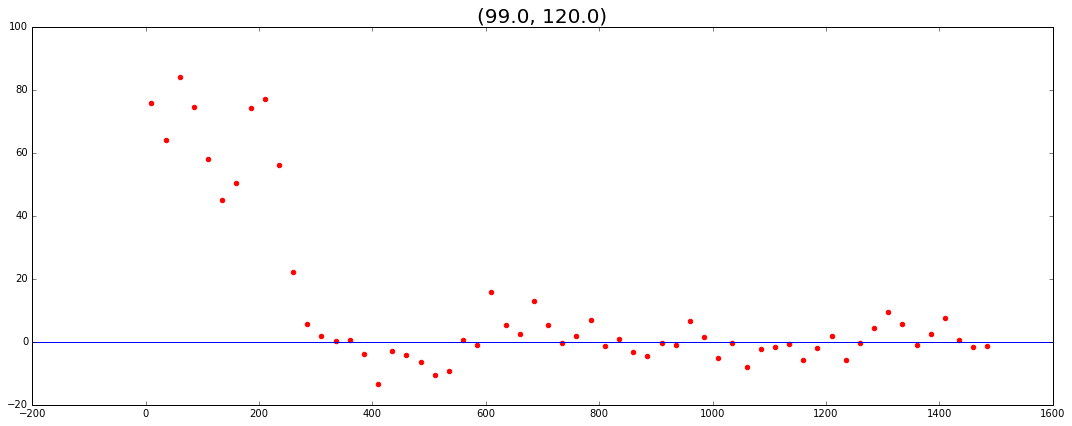

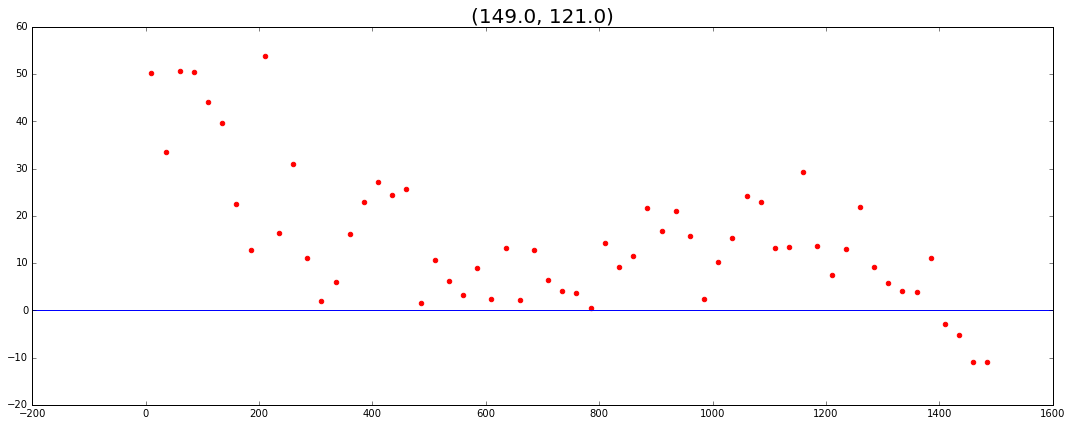

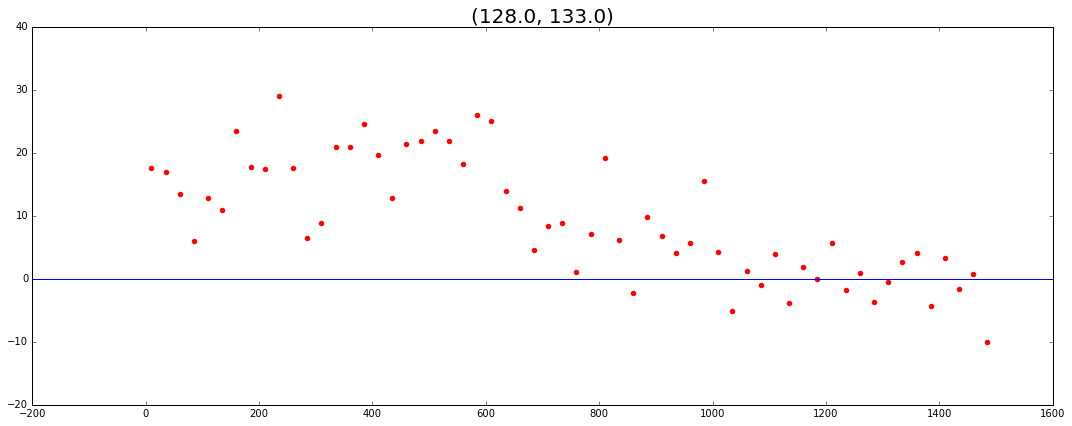

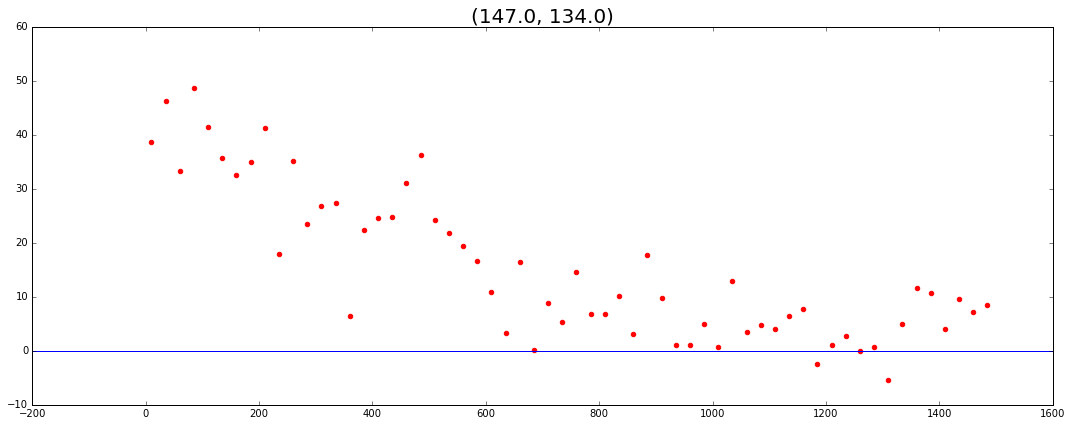

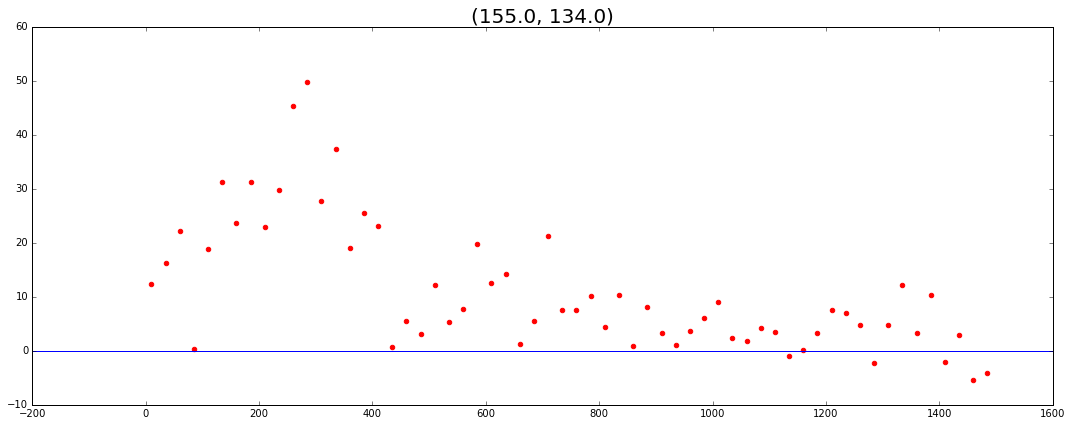

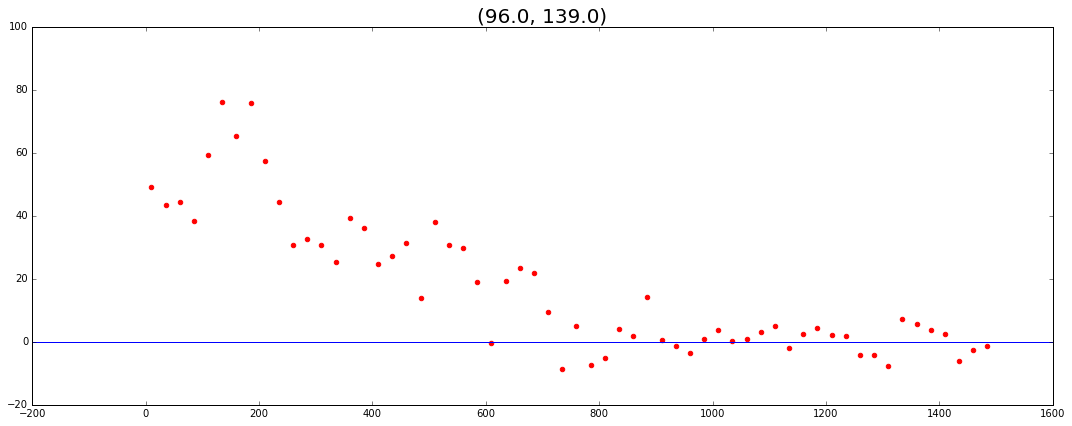

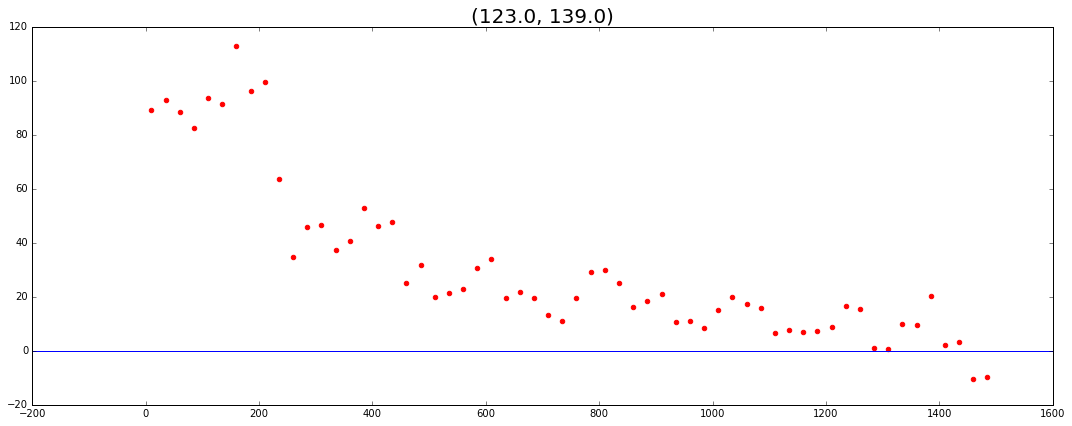

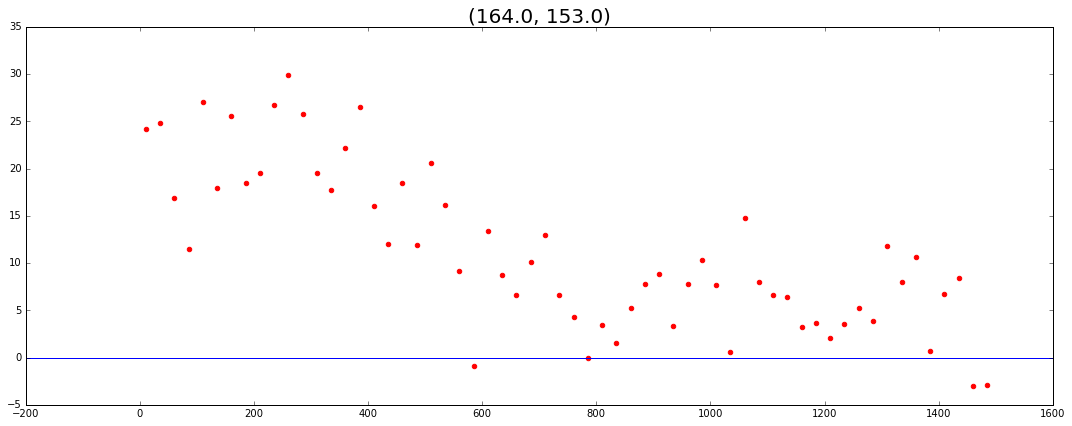

In [42]:
vals2 =np.arange(0,len(files))
vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))

for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    coefs = poly.polyfit(vals,SpotAreaHHB[x], 3) # fits 11th order poly 
    ffit  = poly.polyval(vals, coefs)
    #plt.scatter(vals,SpotAreaHH[x]-SpotAreaHHB[x],color='b')
    plt.scatter(vals,SpotAreaHH[x]-ffit,color='r')
    #plt.scatter(vals,SpotAreaHHB[x],color='g')
    #plt.plot(vals,ffit)
    #plt.scatter(vals[gradval1[x][0][-1]+3:gradval1[x][0][-1]+3],SpotAreaHH2[x][gradval1[x]-5:gradval1[x]+5],color='k')

    
    #plt.plot(vals,np.gradient(SpotAreaHH[x]-SpotAreaHHB[x]))
    #plt.plot(vals,np.gradient(SpotAreaHH[x]),color='r')
    #plt.plot(vals,np.gradient(SpotAreaHHB[x]),color='g')
    #plt.scatter(vals,BackG[x])
    #plt.axvline(vals[Bleach[x]],color='steelblue',linewidth=2)
    
    #plt.axvline(vals[gradval1[x]],color='r',linewidth=2)
    
    #plt.axhline(70)
    plt.axhline(0)
    #plt.axhline(20,color='g')

    plt.tight_layout()
    plt.show()

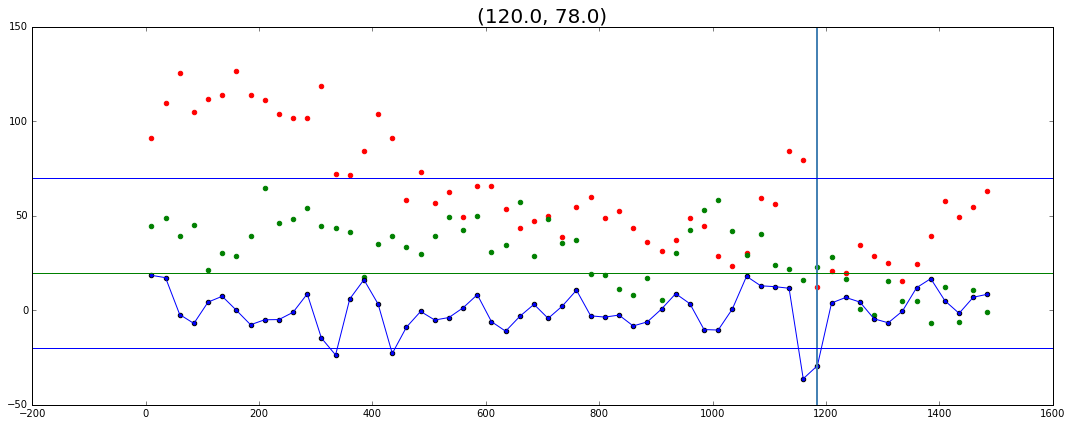

In [63]:
vals2 =np.arange(0,len(files))
vals = np.add.reduceat(vals2, np.arange(0, len(vals2), 5))

for x in range(0,len(PairsMade2)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade2[x],fontsize=20)
    plt.scatter(vals,SpotAreaHH2[x],color='r')
    plt.scatter(vals,SpotAreaHHB2[x],color='g')
    #plt.scatter(vals[gradval1[x][0][-1]+3:gradval1[x][0][-1]+3],SpotAreaHH2[x][gradval1[x]-5:gradval1[x]+5],color='k')

    
    plt.plot(vals,np.gradient(SpotAreaHH2[x]))
    plt.scatter(vals,np.gradient(SpotAreaHH2[x]))
    #plt.scatter(vals,BackG[x])
    plt.axvline(vals[Bleach[x]],color='steelblue',linewidth=2)
    
    #plt.axvline(vals[gradval1[x]],color='r',linewidth=2)
    
    plt.axhline(70)
    plt.axhline(-20)
    plt.axhline(20,color='g')

    plt.tight_layout()
    plt.show()

In [32]:
AT = np.array([4,8,8,4,8,8,8,8,8,3,3,3,7,3,3,4])
TT = np.arange(len(AT))

In [33]:
AT

array([4, 8, 8, 4, 8, 8, 8, 8, 8, 3, 3, 3, 7, 3, 3, 4])

In [34]:
thold = 5
Cut2 = AT
High = []
Low = []
for x in range(0,len(Cut2)):
    if Cut2[x] >= thold:
        High.append(x)
    elif Cut2[x] < thold:
        Low.append(x)
pos=[]
for x in range(0,len(High)):
    if all(i >= High[x] for i in Low):# all low must be bigger than high!
        pos.append(1)
    else:
        pos.append(0)
pos   # the number of ones is the time to bleach



[0, 0, 0, 0, 0, 0, 0, 0]

In [108]:
pos.count(1)

8

In [122]:
SpotAreaHH2 = []
PairsMade2 = []
Bleach = []
for x in range(0,len(PairsMade)):
    thold = 70
    Cut2 = SpotAreaHH[x]
    CutP = PairsMade[x]
    High = []
    Low = []
    for x in range(1,len(Cut2)):
        if Cut2[x] >= thold:
            High.append(x)
        elif Cut2[x] < thold:
            Low.append(x)
    pos=[]
    for x in range(0,len(High)):
        if all(i >= High[x] for i in Low):# all bad must be bigger than good!
            pos.append(1)
        else:
            pos.append(0)
    if pos.count(1)>=1:
        SpotAreaHH2.append(Cut2)
        PairsMade2.append(CutP)  
        Bleach.append(pos.count(1))


In [ ]:
qq = 

In [188]:
qe = np.ones(5**2).reshape((5,5))*0
qe

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [189]:
qw = np.ones(9**2).reshape((9,9))
qw

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [190]:
qw[2:7,2:7]=qe
qw

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [191]:
fake1 = np.ones(9**2).reshape((9,9))*5
fake2 = np.ones(9**2).reshape((9,9))*5
spot = fake1[2:7,2:7]
SpotRemove = np.zeros(5**2).reshape((5,5))
fake2[2:7,2:7]=SpotRemove
Back = fake2

In [192]:
spot

array([[ 5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.]])

In [193]:
Back

array([[ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  5.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  5.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  5.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  5.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.]])

In [ ]:
Par = len(AllPairs)
AreaCut = 70
AreaH=[]
AreaHH=[]
SpotAreaH=[]
SpotAreaHH=[]
PairsMade=[]
gradval1 = []
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), 5))/5
    AreaH.append(HoldArea)
    AreaHH.append(aa)

    aboveCut = len([i for i in aa if i > AreaCut])
    gd = np.gradient(aa)
    grad = gd[3:len(gd)-3]
    #if aboveCut > 10 :
    if min(grad)<-20 and max(grad)<20 and aboveCut > 10:
        SpotAreaH.append(HoldArea)
        SpotAreaHH.append(aa)
        PairsMade.append(AllPairs[x])
        gradval1.append(np.where(grad<-20)[0][0]+3)##### add 5 for the - 3 in gd!
    
PairsMade2=[]    
SpotAreaHH2=[]
Bleach=[]
for x in range(0,len(PairsMade)):
    thold = 70
    Cut2 = SpotAreaHH[x]
    CutP = PairsMade[x]
    High = []
    Low = []
    for x in range(1,len(Cut2)):
        if Cut2[x] >= thold:
            High.append(x)
        elif Cut2[x] < thold:
            Low.append(x)
    pos=[]
    for x in range(0,len(High)):
        if all(i >= High[x] for i in Low):# all bad must be bigger than good!
            pos.append(1)
        else:
            pos.append(0)
    if pos.count(1)>=1 and len(pos)!=pos.count(1):
        SpotAreaHH2.append(Cut2)
        PairsMade2.append(CutP)  
        Bleach.append(pos.count(1))



In [ ]:
Par = len(AllPairs)
AVG = 5
AreaCut = 30
AreaH=[]
AreaHH=[]
SpotAreaH=[]
SpotAreaHH=[]
PairsMade=[]
gradval1 = []
SpotAreaHHB = []
SpotAreaHHB2 = []

for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,4]
    HoldAreaB = HoldAreaB*(25/56)
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
    AreaH.append(HoldArea)
    AreaHH.append(aa)

    aboveCut = len([i for i in aa if i > AreaCut])
    gd = np.gradient(aa)
    grad = gd[3:len(gd)-3]
    #if aboveCut > 10 :
    if aboveCut > 10:#min(grad)<-20 and and max(grad)<20
        SpotAreaH.append(HoldArea)
        SpotAreaHH.append(aa)
        SpotAreaHHB.append(aaB)
        PairsMade.append(AllPairs[x])
        gradval1.append(np.where(grad<-20))##### add 3 for the - 3 in gd!
    
#PairsMade2=[]    
#SpotAreaHH2=[]
#Bleach=[]
#for x in range(0,len(PairsMade)):
#    gradval2 = gradval1[x][0][-1]+3 ##### add 3 for the - 3 in gd!
#    thold = 70
#    Cut2 = SpotAreaHH[x]
#    CutP = PairsMade[x]
#    frontMean = np.mean(Cut2[:gradval2])
#    endMean   = np.mean(Cut2[gradval2:])
#    if frontMean > 2*endMean:
##        SpotAreaHH2.append(Cut2)
 #       PairsMade2.append(CutP)  
#       Bleach.append(gradval2) 
#        SpotAreaHHB2.append(aaB)
    

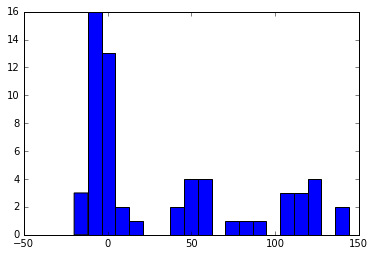

In [127]:
plt.hist(SpotAreaHH2[1],bins=20)
plt.show()

In [44]:
Par = len(AllPairs)
SpotArea = []
PairsMade = []
AreaCut = 4e3

for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    aboveCut = len([i for i in HoldArea if i > AreaCut])
    grad = abs(np.gradient(HoldArea))
    #if aboveCut > 5 :
    if max(grad)>2e3 and aboveCut > 10:
        SpotArea.append(HoldArea)
        PairsMade.append(AllPairs[x])
        

len(PairsMade)

75

In [60]:
Par = len(AllPairs)
SpotAreaHH = []
SpotArea = []
PairsMade = []
AreaCut = 2e3

for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), 5))/5
    aaa = aa-min(aa)
    #SpotAreaHH.append(aaa)
    aboveCut = len([i for i in aaa if i > AreaCut])
    grad = abs(np.gradient(aaa))
    #if aboveCut > 5 :
    if max(grad)>2e3 and aboveCut > 10:
        SpotArea.append(aaa)
        PairsMade.append(AllPairs[x])
        

len(PairsMade)


15

In [61]:
len(SpotArea)

15

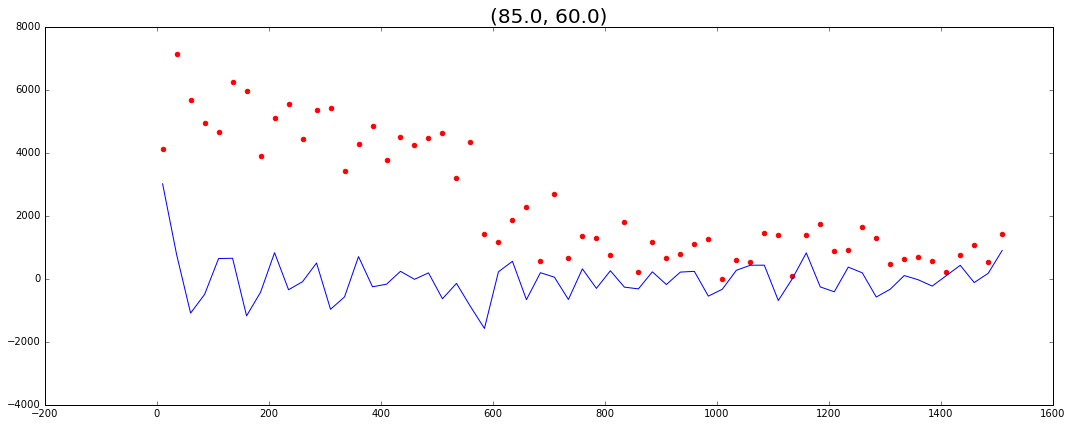

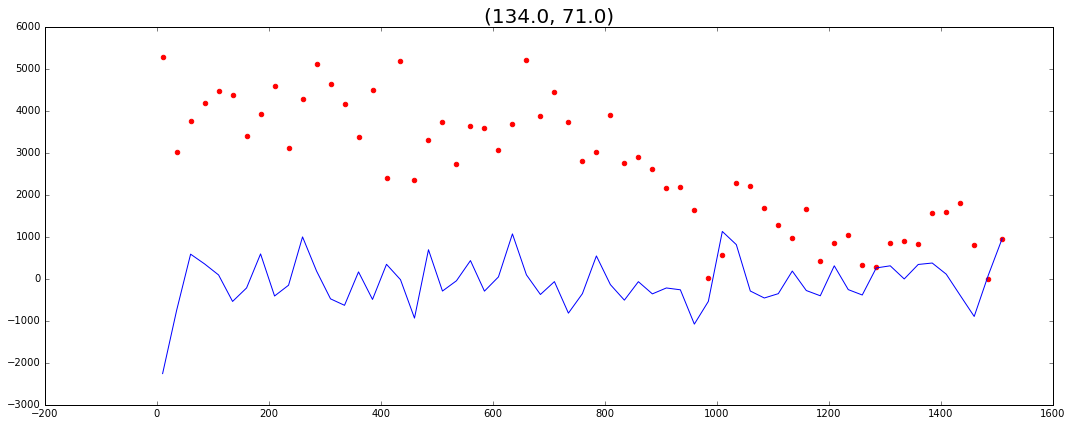

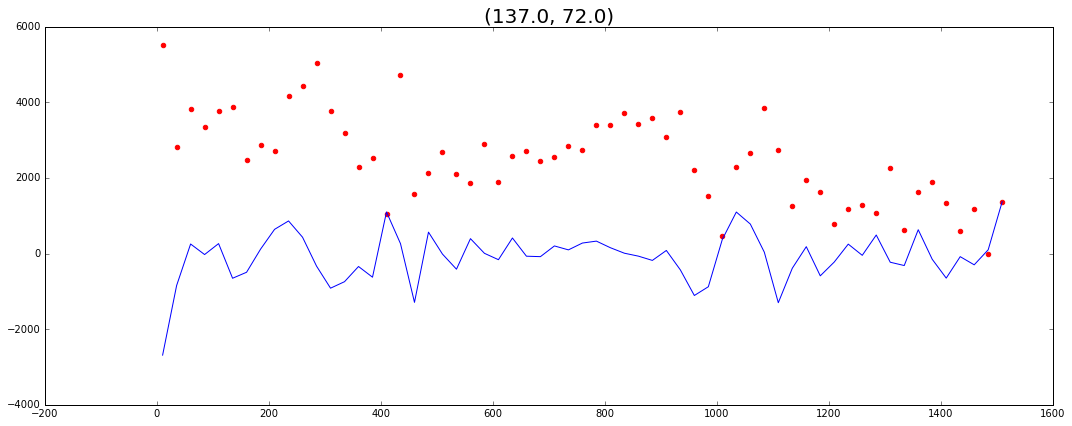

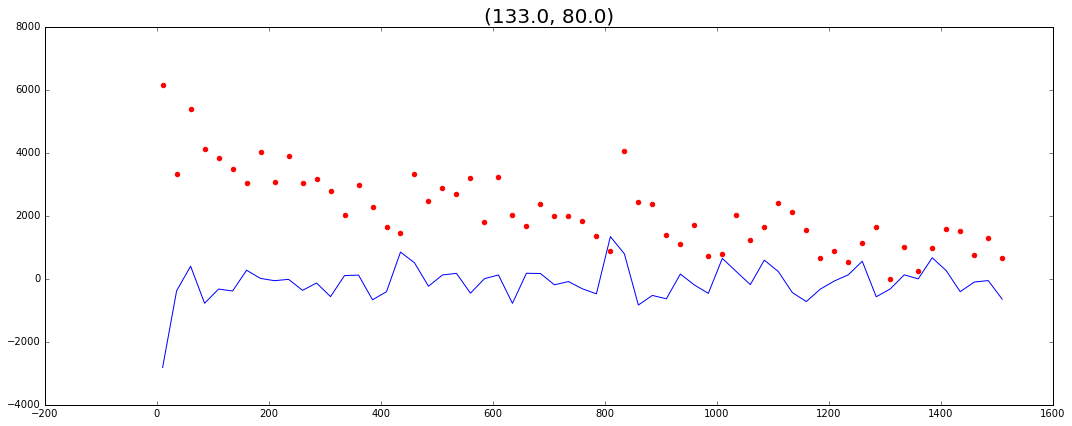

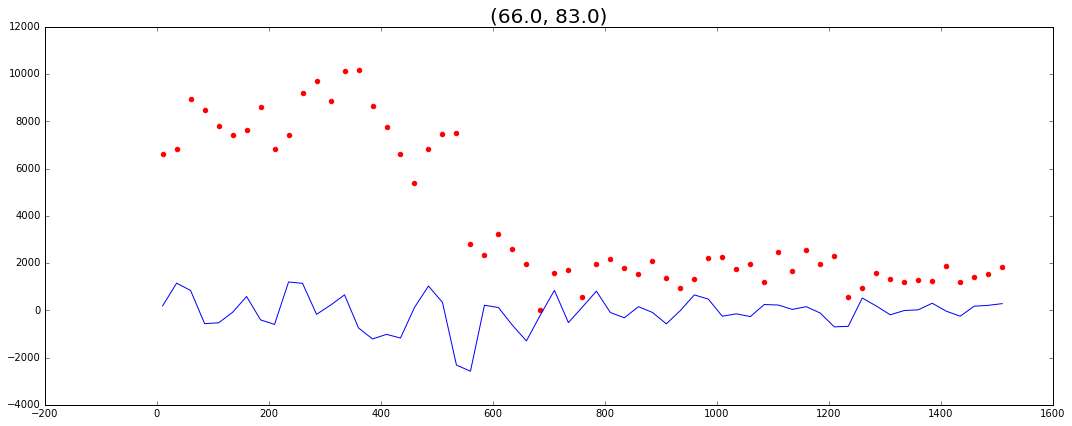

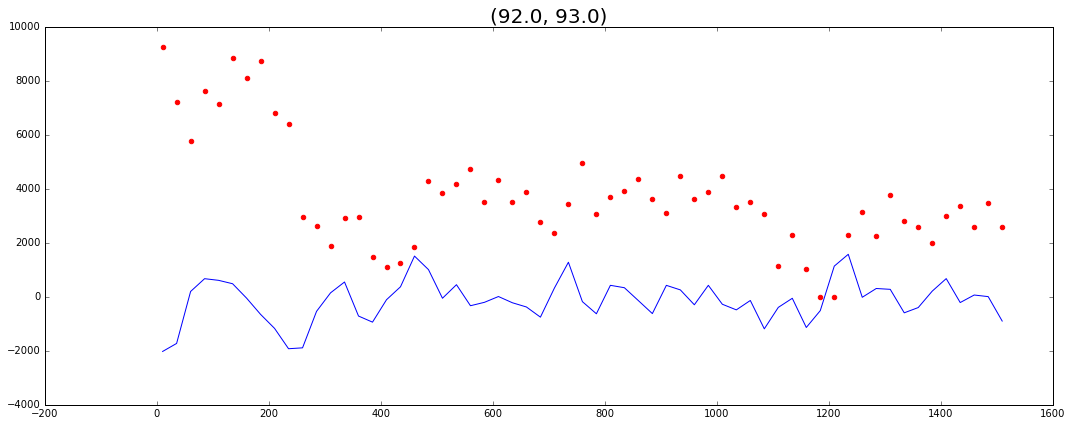

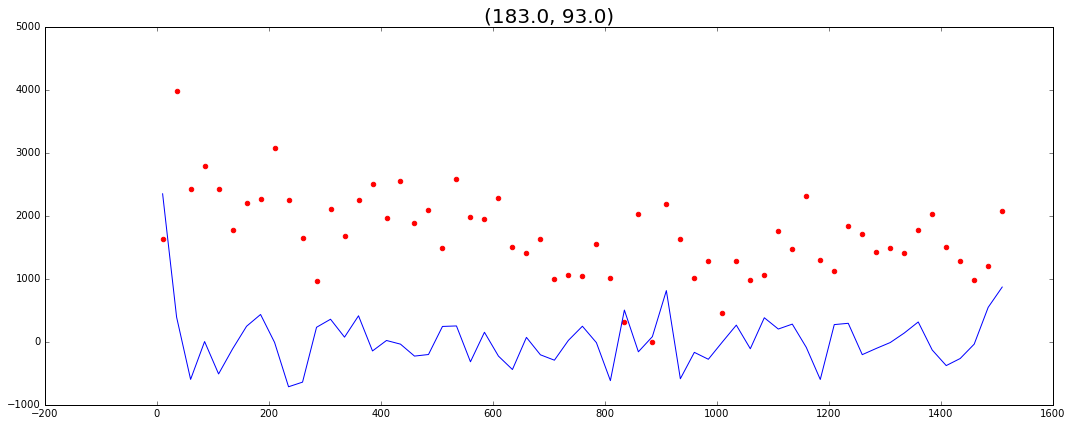

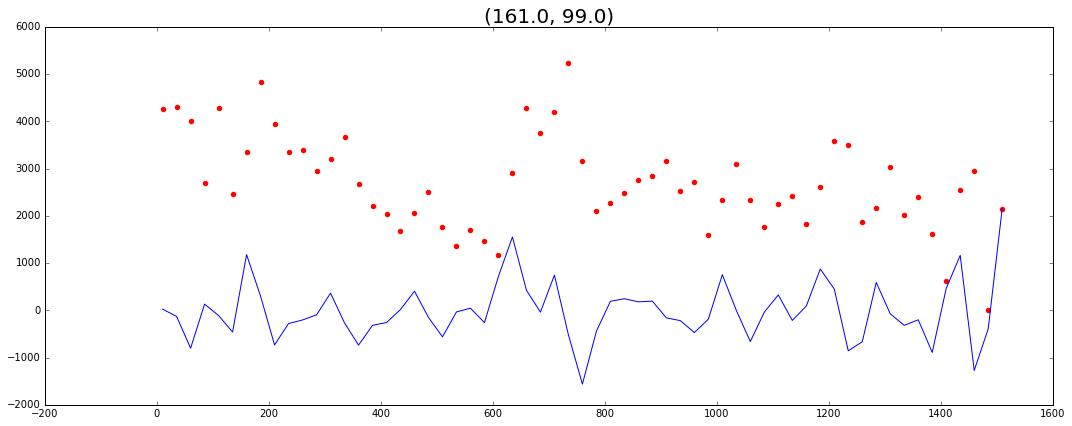

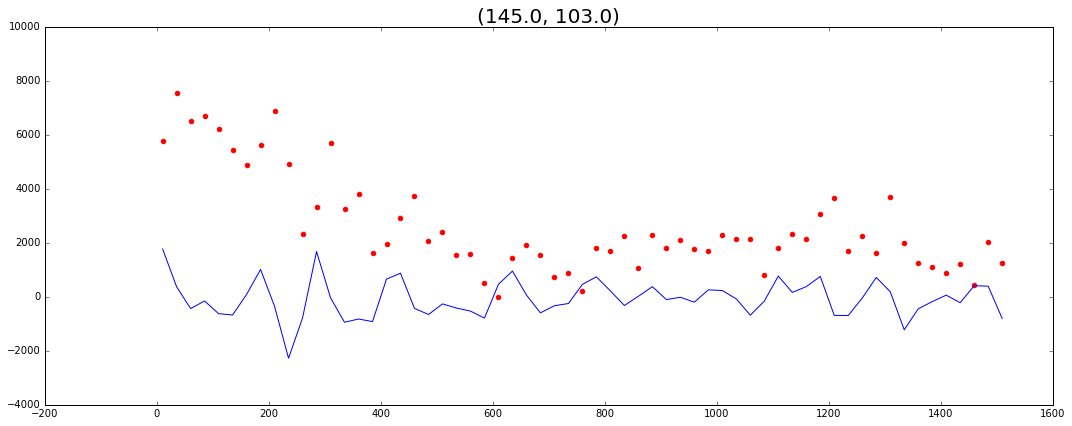

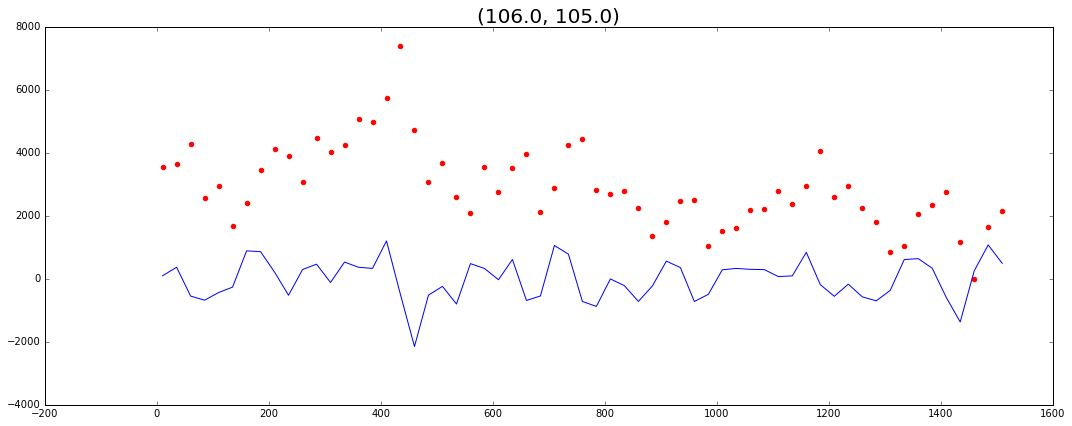

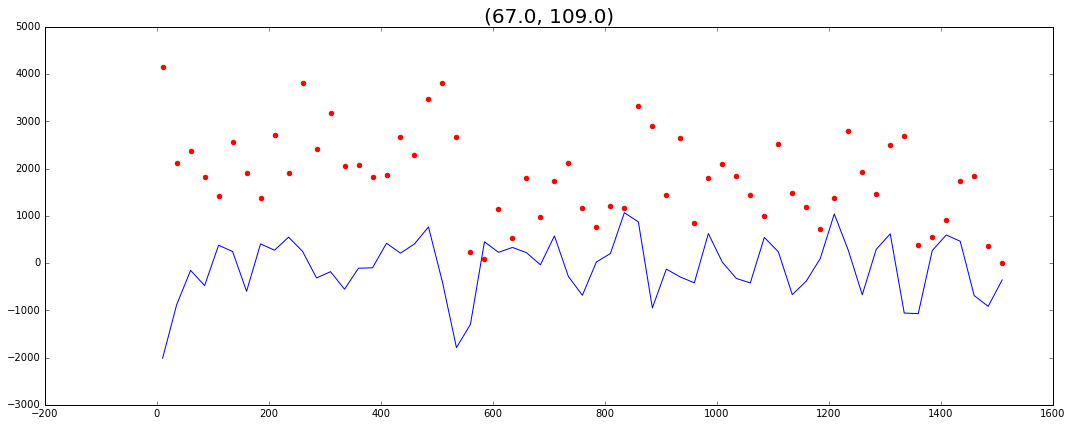

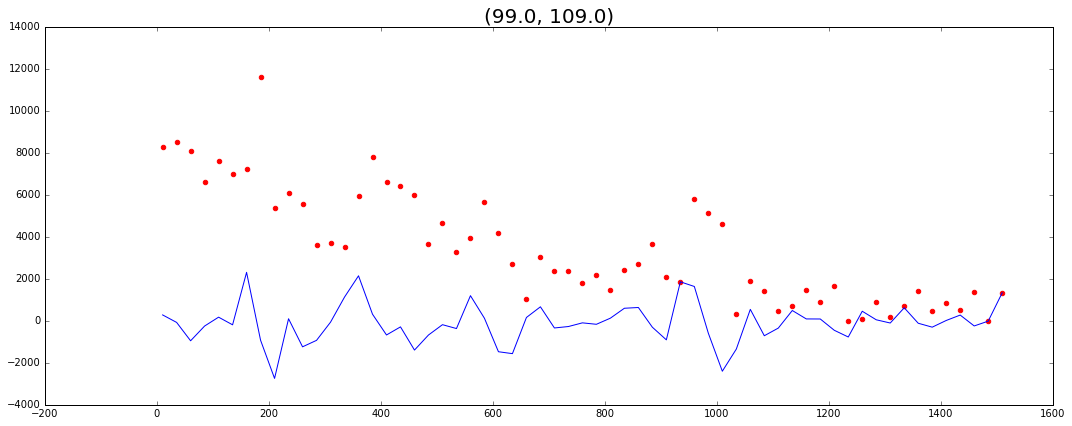

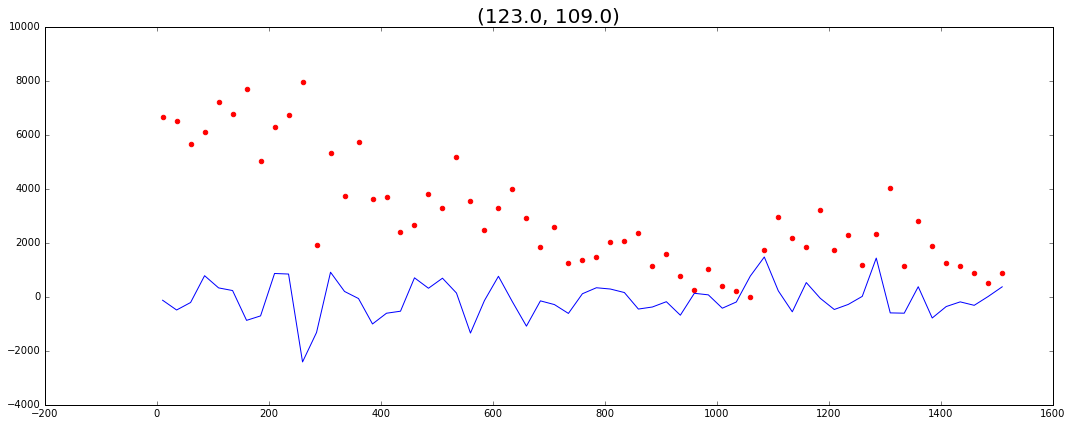

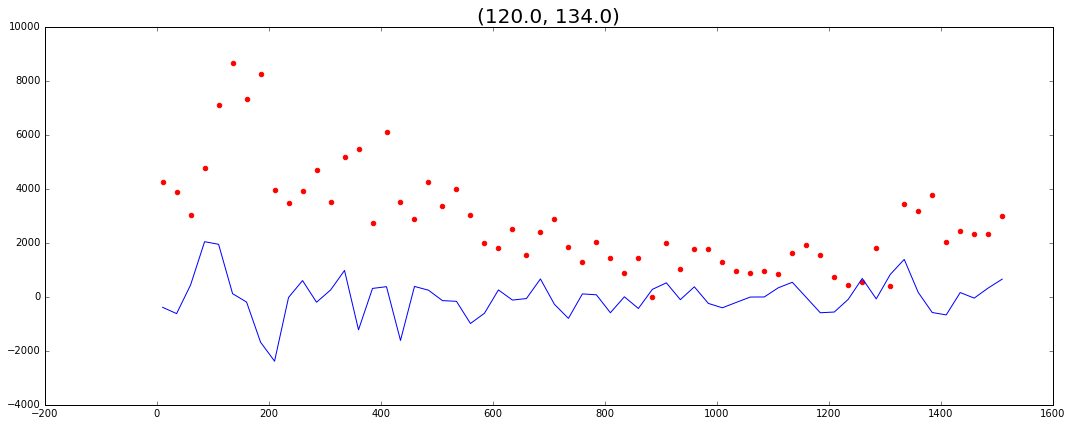

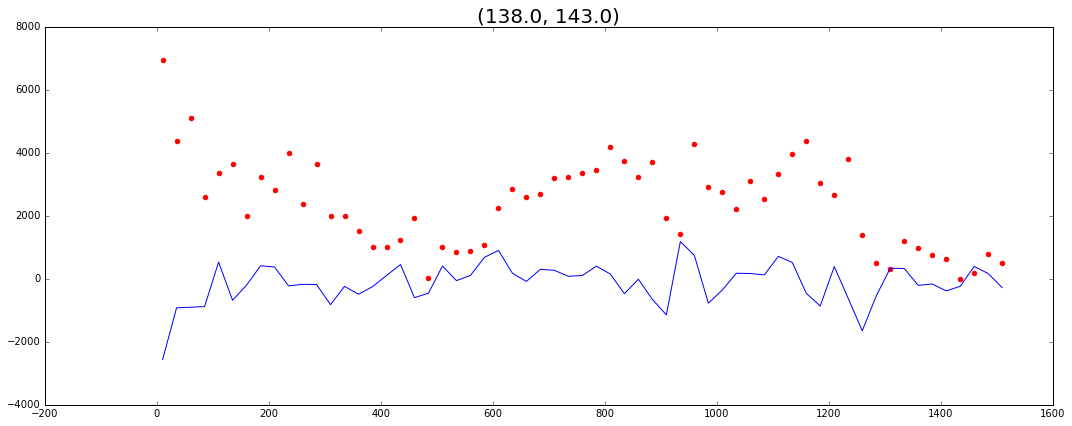

In [62]:
vals2 =np.arange(0,len(files))
vals = np.add.reduceat(vals2, np.arange(0, len(vals2), 5))

for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    plt.scatter(vals,SpotArea[x],color='r')
    plt.plot(vals,np.gradient(SpotArea[x]))
    #plt.scatter(vals,BackG[x])
    plt.tight_layout()
    plt.show()

ValueError: x and y must be the same size

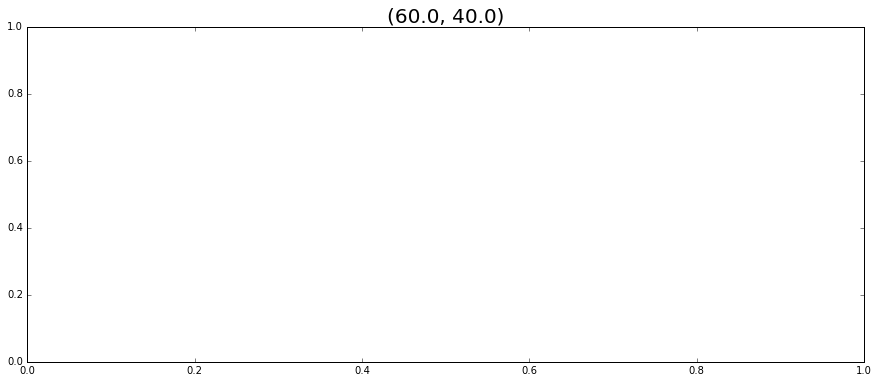

In [47]:
vals =np.arange(0,len(files))
vals2 = np.add.reduceat(vals, np.arange(0, len(vals), 5))
for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    aa = np.add.reduceat(SpotArea[x], np.arange(0, len(SpotArea[x]), 5))/5
    plt.scatter(vals2,aa-np.mean(aa),color='r')
    plt.plot(vals2,np.gradient(aa))
    #plt.scatter(vals,BackG[x])
    plt.tight_layout()
    plt.show()

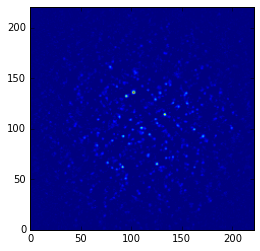

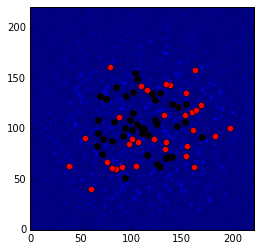

In [21]:
plt.imshow(testt)
plt.xlim(0,221)
plt.ylim(0,221)
plt.show()
plt.imshow(testt)
a,b = zip(*AllPairs)
plt.plot(a,b, 'ro')
c,d = zip(*PairsMade)
plt.plot(c,d, 'ko')
plt.xlim(0,221)
plt.ylim(0,221)
plt.show()

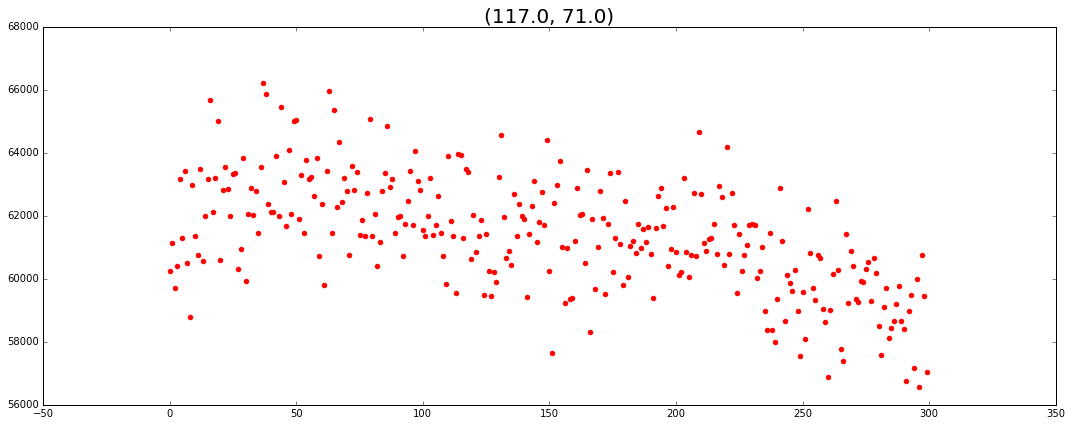

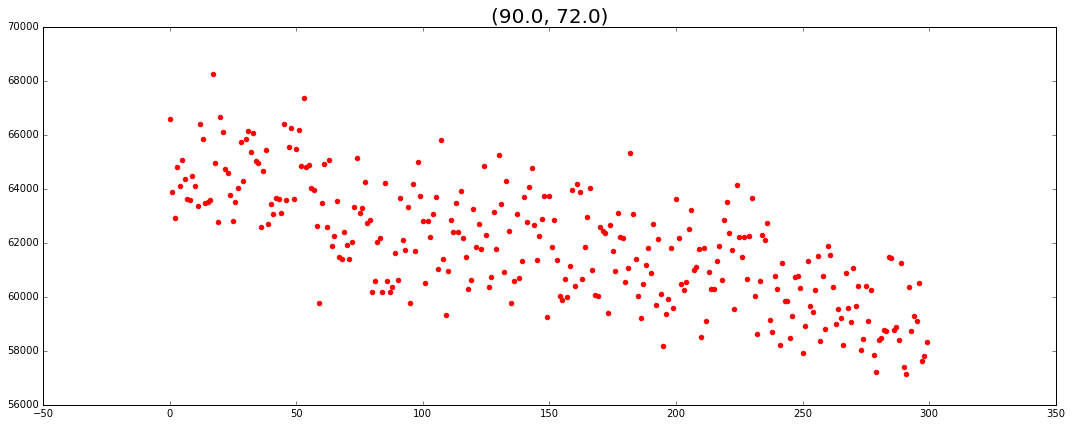

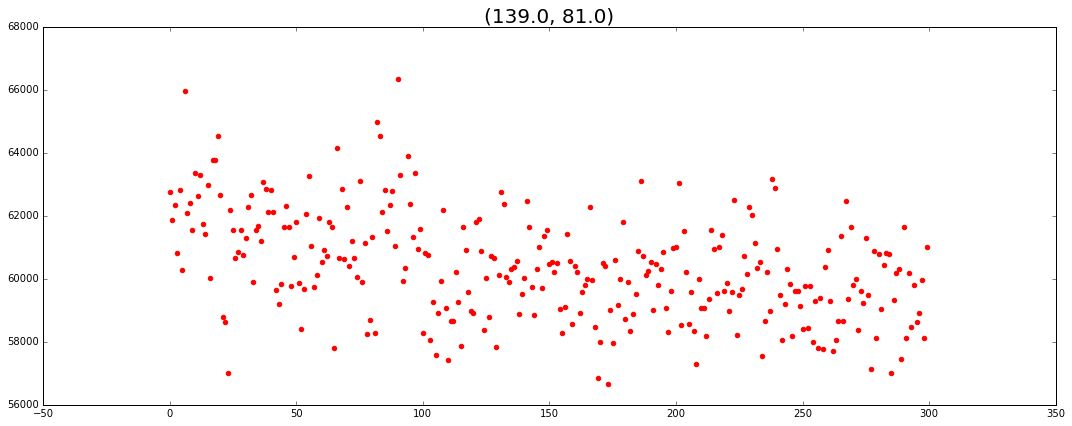

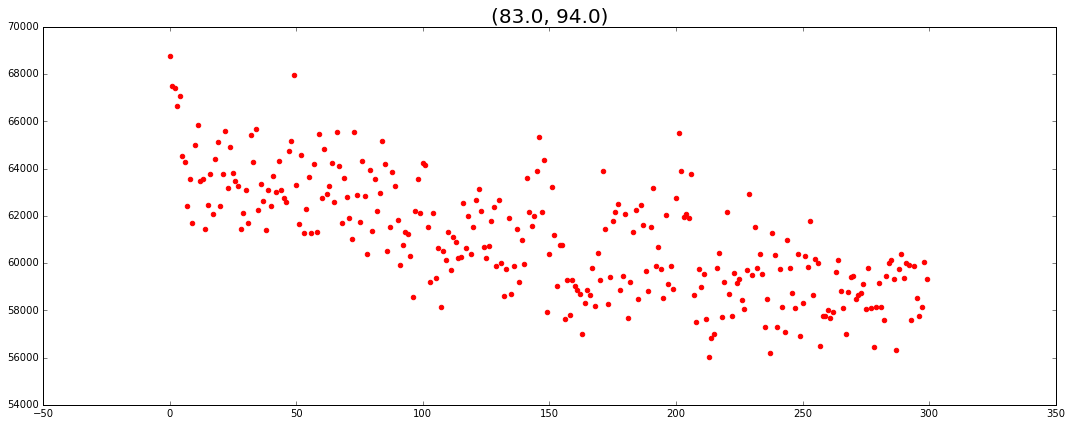

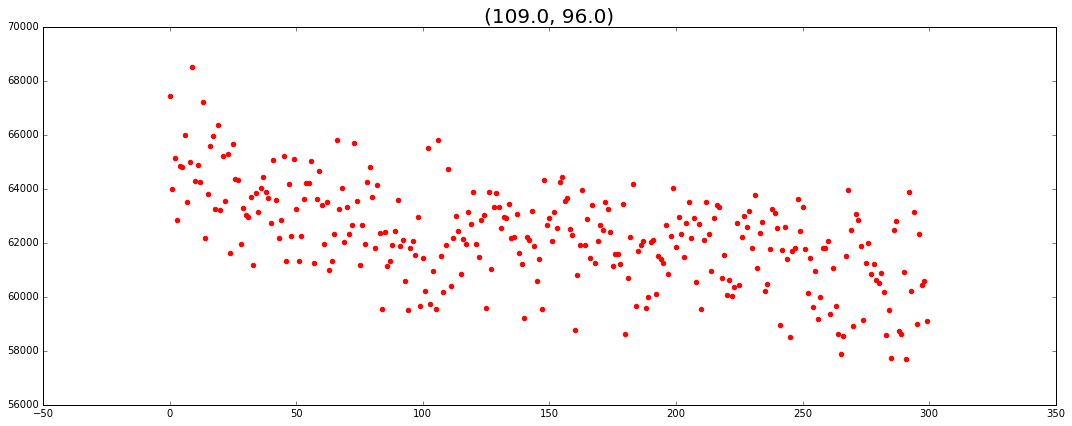

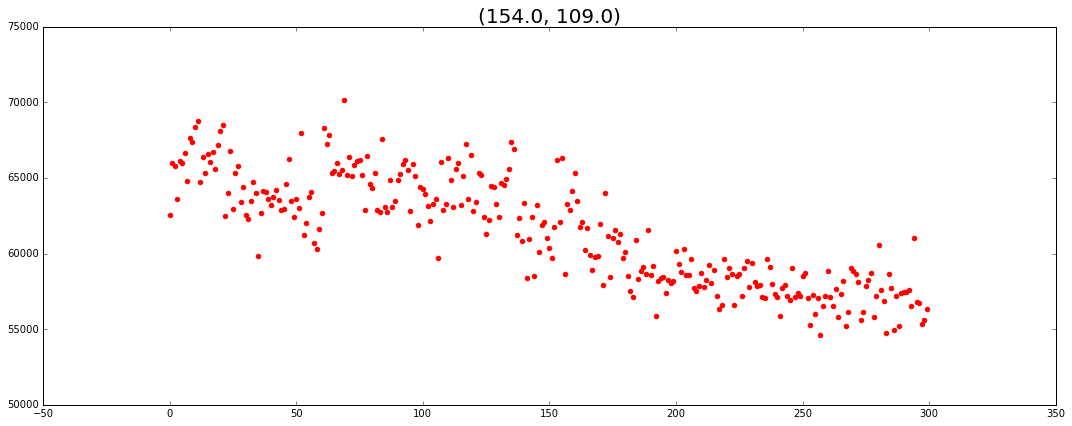

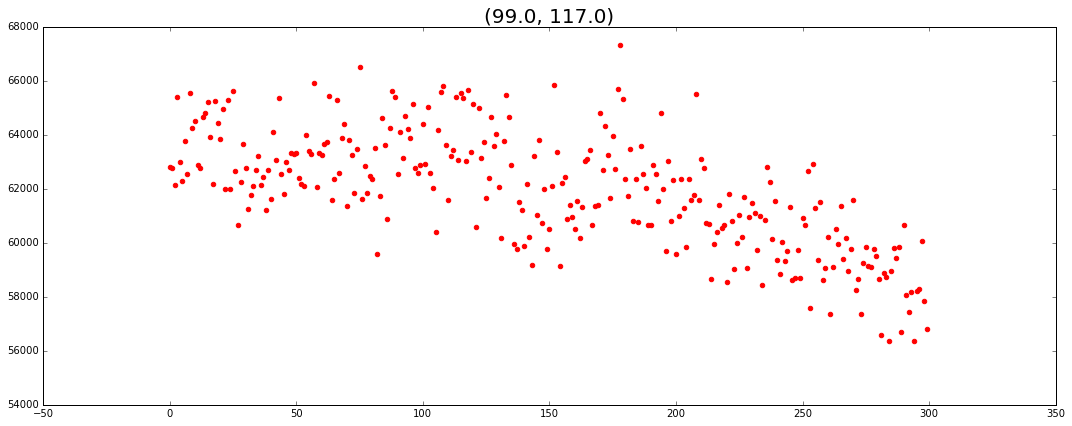

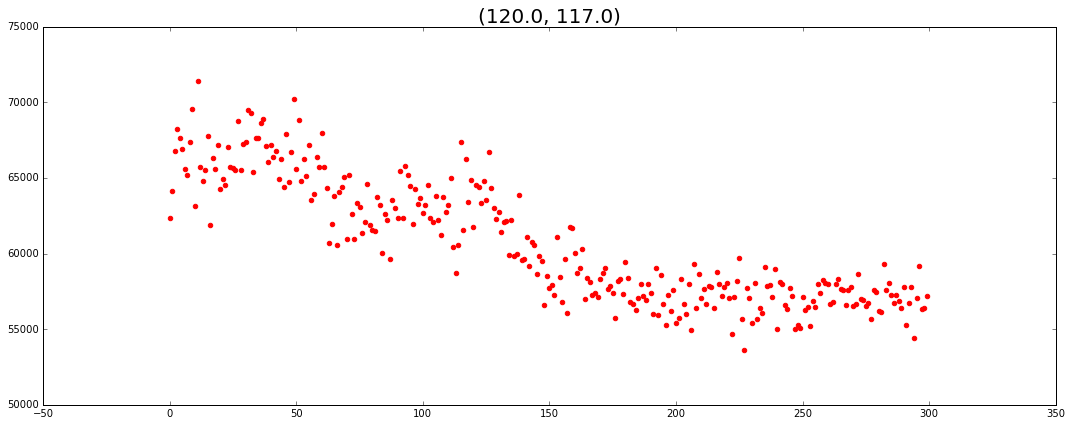

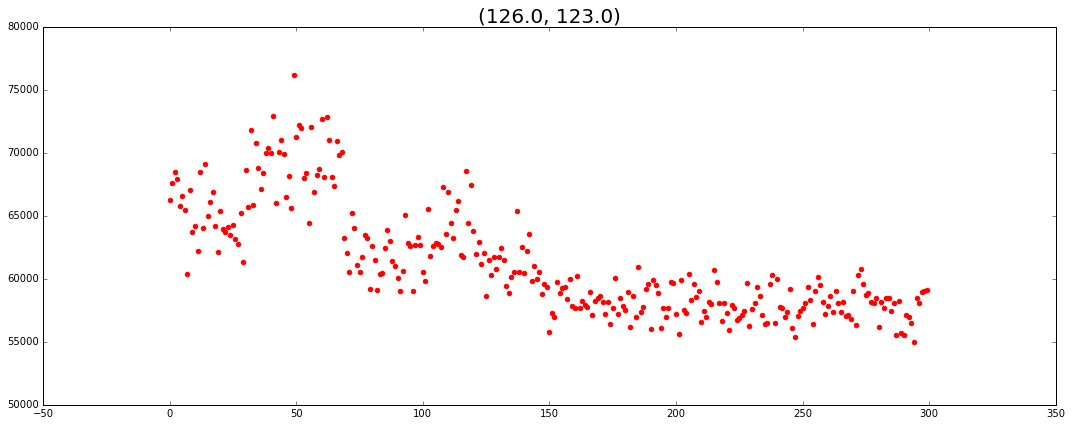

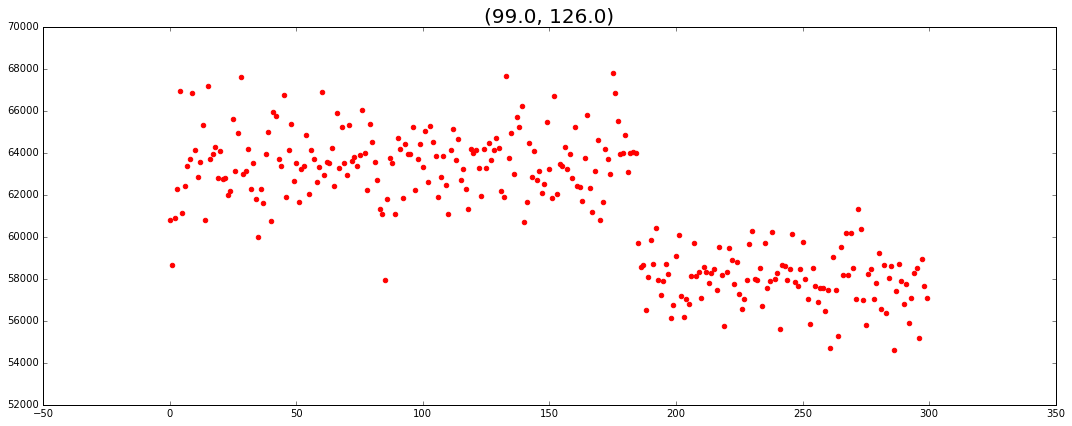

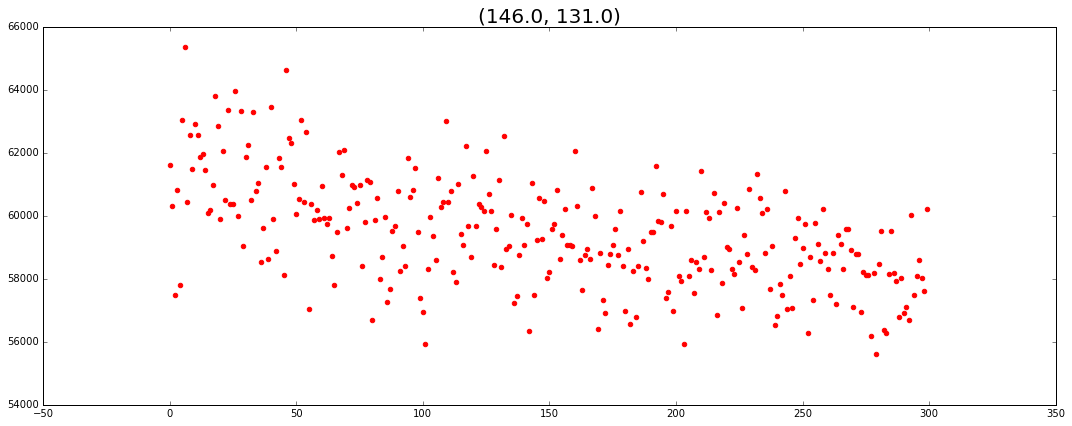

In [77]:
vals =np.arange(0,len(files))
for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    plt.scatter(vals,SpotArea[x],color='r')
    #plt.plot(vals,np.gradient(SpotArea[x]))
    #plt.scatter(vals,BackG[x])
    plt.tight_layout()
    plt.show()

In [ ]:
vals =np.arange(0,len(files))
for x in range(0,len(PairsMade)):
    plt.figure(figsize=(15,6))
    plt.title(PairsMade[x],fontsize=20)
    plt.scatter(vals,SpotArea[x],color='r')
    plt.plot(vals,np.gradient(SpotArea[x]))
    #plt.scatter(vals,BackG[x])
    plt.tight_layout()
    plt.show()

In [15]:
xvs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

(0, 510)

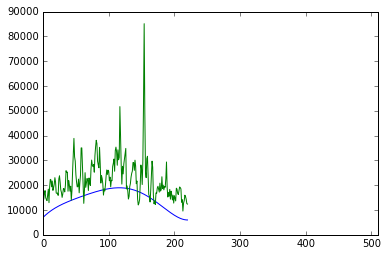

In [28]:
#sxvs = savgol_filter(xvs, 11, 6)
#sdat = savgol_filter(Imdat[250], 11, 6)
#ma = np.ma.array(Imdat[250])

coefs = poly.polyfit(xvs, DataSub[110], 5)
ffit = poly.polyval(xvs, coefs)
plt.plot(xvs, ffit-np.std(DataSub[110]))
plt.plot(xvs,DataSub[110])
#plt.plot(sxvs,sdat)
#plt.plot(maxvs,ma,color='y')
plt.xlim(0,510)
#plt.ylim(2000,12000)

In [27]:
np.std(DataSub[110])

8266.4880522349922

In [ ]:
SpotInfo2 = []
AllPairs =[]
Shape = 221
Row = int(2) # define the area to take around the spots
Col = int(2) # define the area to take around the spots
xvs = np.arange(0,Shape)
#DataS=np.zeros(Shape**2).reshape((Shape,Shape))
neighborhood_size = 5

ct = 0
DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
Datatot = DataSub
for q in range(0,len(files)):
    Images = np.array(Image.open(files[q]))
    ImageB = []
    for x in range(0,Shape):
        coefs = poly.polyfit(xvs, Images[x], 11) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        hold  = Images[x]-(ffit)
        hold[hold < 0] = 0        # replaces negtive values form the sub with 0
        ImageB.append(hold)
    DataSub += ImageB
    #Datatot += ImageB
    #ct += 1
    #if ct > 20:
     #   ct = 0
data = DataSub
    #DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
threshold = 2*np.mean(data)
#threshold = 6*np.std(data)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 
        
clear_output()
print('Finding AllPairs')
print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))   
Images = None
ImageB = None
data   = None
Slices = None
labeled= None
num_objects=None
    
############################################################## 

Xc,Yc = zip(*AllPairs)

for q in range(0,len(files)):
    Images = np.array(Image.open(files[q]))
    ImageB = []
    for x in range(0,81):
        coefs = poly.polyfit(xvs, Images[x], 11) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        hold  = Images[x]-(ffit)
        hold[hold < 0] = 0        # replaces negtive values form the sub with 0
        ImageB.append(hold)

    ImageB = np.array(ImageB)
    SpotInfoHolder = []

    for w in range(0,len(Xc)):
        Xindex = int(Xc[w])
        Yindex = int(Yc[w])
        spot = ImageB[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1]
        ATot = spot.sum()
        SpotInfo2.append([q,Xindex,Yindex,ATot])

##############################################################  
       
    clear_output()
    print('Finding all areas') 
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))
